In [0]:
# Approach
# make attention at 2 points
# 1. having 2 hops
# 2. sigmid attention

# sigmoid attention

In [0]:
# !rm da*
# !rm mem*
# !rm sim*

from __future__ import absolute_import
from __future__ import print_function

from sklearn import metrics
# from memn2n import MemN2N
from itertools import chain
from six.moves import range, reduce
import re

import tensorflow as tf
from tensorflow import keras

import numpy as np

from google.colab import files

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

# uploaded = files.upload()
# uploaded = None

In [0]:

# ############################ data utils

def load_task(train_file, only_supporting=False, test_count=11):
    train_data = parse_stories(train_file[:-1 * test_count], only_supporting)
    test_data = parse_stories(train_file[-1 * test_count:], only_supporting)
    return train_data, test_data


def load_task3(train_file, only_supporting=False, test_count=10):
    #   filter for binary rules
    train2_data = list()
    for line in train_file:
        line = line.replace('\n', '')
        #     line = str.lower(line)
        # 		line = str.lower(line)
        #     print line
        _, qna = line.split('##')
        if (len(qna.split(' ')) == 3):
            train2_data.append(line)

    train_data = parse_stories3(train2_data[:-1 * test_count], only_supporting)
    test_data = parse_stories3(train2_data[-1 * test_count:], only_supporting)
    print('lens', len(train2_data), '#', len(train_data), '#', len(test_data))
    return train_data, test_data


# len(parse_stories(train_data[:-11], False)),len(parse_stories(train_data[-11:], False))

def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]


def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbI tasks format
    If only_supporting is true, only the sentences that support the answer are kept.
    '''
    # In circle O , diameter AB is perpendicular to chord CD at E .##perpendicular AB CD

    data = []
    story = []
    for line in lines:
        story = []
        line = line.replace('\n', '')
        #     line = str.lower(line)
        # 		line = str.lower(line)
        #     print line
        fact1, qna = line.split('##')
        # q, a, supporting = line.split('\t')

        #     a = tokenize(a)

        fact1 = tokenize(fact1)
        if fact1[-1] == "?" or fact1[-1] == ".":
            fact1 = fact1[:-1]

        story.append(fact1)
        # a = tokenize(a)
        # answer is one vocab word even if it's actually multiple words
        #     a = [a]

        qna = qna.split(' ')
        if (len(qna) == 3):
            q1, a1 = qna[0], qna[1:]
            q1 = ' '.join(q1)
            q1 = tokenize(q1)
            data.append((story, q1, a1))

    return data


def parse_stories3(lines, only_supporting=False):
    '''Parse stories provided in the bAbI tasks format
    If only_supporting is true, only the sentences that support the answer are kept.
    '''
    # In circle O , diameter AB is perpendicular to chord CD at E .##perpendicular AB CD

    data = []
    story = []
    for line in lines:
        story = []
        line = line.replace('\n', '')
        #     line = str.lower(line)
        # 		line = str.lower(line)
        #     print ('line', line)
        fact1, qna = line.split('##')
        # q, a, supporting = line.split('\t')

        #     a = tokenize(a)

        fact1 = tokenize(fact1)
        if fact1[-1] == "?" or fact1[-1] == ".":
            fact1 = fact1[:-1]

        for word in fact1:
            story.append(word)
        # story.append(fact1)
        # a = tokenize(a)
        # answer is one vocab word even if it's actually multiple words
        #     a = [a]
        #     print('qna',qna)
        qna = qna.split(' ')
        if (len(qna) == 3):
            q = qna[0]
            a1 = qna[1]
            a2 = qna[2]
            data.append((story, [q], [a1,a2]))
    return data


def vectorize_datas(data, word_idx, sentence_size, memory_size):
    """
    Vectorize stories and queries.

    If a sentence length < sentence_size, the sentence will be padded with 0's.

    If a story length < memory_size, the story will be padded with empty memories.
    Empty memories are 1-D arrays of length sentence_size filled with 0's.

    The answer array is returned as a one-hot encoding.
    """
    S = []
    Q = []
    A1 = []
    A2 = []
    
    # 	print('data',data)
    for story, query, answer in data:
#         print(story, query, answer)
        # story ['In', 'the', 'accompanying', 'diagram', 'of', 'circle', 'O', ',', 'the', 'measure', 'of', 'angle', 'ABC', 'is', '@', 'v_0', 'and', 'the', 'measure', 'of', 'arc', 'AC', 'is', '@', 'v_1']

        if "_on" in query[0]: 
          query[0].replace('_on', '')
        
        if ((answer[0] not in story) or (answer[1] not in story) or (query[0] not in story) or (len(query) > 1 and query[1] not in story)):
            continue

        q_position = story.index(query[0])
        ss = []
        for i, sentence in enumerate(story, 1):
            ls = 1
            # 			print('ls, sentence_size, sentence', ls, sentence, sentence_size, query)
            #       ls, sentence_size, sentence 1 accompanying 2 ['is']
            ss.append([word_idx[sentence]] + [0] * ls)
        # print('[word_idx[sentence]] + [0] * ls', [word_idx[sentence]] + [0] * ls)
        # 			print('ss', ss)

        # take only the most recent sentences that fit in memory
        ss = ss[::-1][:memory_size][::-1]

        # Make the last word of each sentence the time 'word' which
        # corresponds to vector of lookup table
        ss[q_position][-1] = len(word_idx) - memory_size
        # 		print('ss[q_position][-1] ', ss[q_position][-1], q_position )
        count = 0
        for i in range(q_position - 1, -1, -1):
            count += 1
            # 			print('i', i, ss[q_position][-1] - count)

            ss[i][-1] = ss[q_position][-1] - count

        count = 0
        for j in range(q_position + 1, len(ss)):
            count += 1
            # 			print('j', j, ss[q_position][-1] + count)

            ss[j][-1] = ss[q_position][-1] + count

        # print()

        # 		for i in range(len(ss)):
        # 			ss[i][-1] = len(word_idx) - memory_size - i + len(ss)
        #       i - q_position
        # 		print('ss1', ss)
        # pad to memory_size
        lm = max(0, memory_size - len(ss))
        for _ in range(lm):
            ss.append([0, 0])
        # print('ss2', ss)
        lq = max(0, sentence_size - len(query))
        q = [word_idx[w] for w in query] + [len(word_idx) - memory_size] * lq

        y1 = np.zeros(memory_size)  # 0 is reserved for nil word

        y1 = np.zeros(memory_size)
        y1[story.index(answer[0])] = 1

        A1.append(y1)


        y2 = np.zeros(memory_size)  # 0 is reserved for nil word
        
        y2 = np.zeros(memory_size)
        y2[story.index(answer[1])] = 1
        
        S.append(ss)
        # 		print(q1_position, q2_position, 'ss23', ss)
        Q.append(q)
        A2.append(y2)
    return S, np.array(Q), np.array(A1), np.array(A2)


def vectorize_datas_for_predict(data, word_idx, sentence_size, memory_size):
    """
    Vectorize stories and queries.

    If a sentence length < sentence_size, the sentence will be padded with 0's.

    If a story length < memory_size, the story will be padded with empty memories.
    Empty memories are 1-D arrays of length sentence_size filled with 0's.

    The answer array is returned as a one-hot encoding.
    """
    S = []
    Q = []
    A = []
    # 	print('data',data)
    for story, query, answer in data:
        # 		print(story, query, answer)
        # story ['In', 'the', 'accompanying', 'diagram', 'of', 'circle', 'O', ',', 'the', 'measure', 'of', 'angle', 'ABC', 'is', '@', 'v_0', 'and', 'the', 'measure', 'of', 'arc', 'AC', 'is', '@', 'v_1']

        if ((answer[0] != 'point') and (
                        (answer[0] not in story) or (query[0] not in story) or (
                        len(query) > 1 and query[1] not in story))):
            continue

        q_position = story.index(query[0])
        ss = []
        for i, sentence in enumerate(story, 1):
            ls = 1
            # 			print('ls, sentence_size, sentence', ls, sentence, sentence_size, query)
            #       ls, sentence_size, sentence 1 accompanying 2 ['is']
            ss.append([word_idx[sentence]] + [0] * ls)
        # print('[word_idx[sentence]] + [0] * ls', [word_idx[sentence]] + [0] * ls)
        # 			print('ss', ss)

        # take only the most recent sentences that fit in memory
        ss = ss[::-1][:memory_size][::-1]

        # Make the last word of each sentence the time 'word' which
        # corresponds to vector of lookup table
        ss[q_position][-1] = len(word_idx) - memory_size
        # 		print('ss[q_position][-1] ', ss[q_position][-1], q_position )
        count = 0
        for i in range(q_position - 1, -1, -1):
            count += 1
            # 			print('i', i, ss[q_position][-1] - count)

            ss[i][-1] = len(word_idx) - memory_size

        count = 0
        for j in range(q_position + 1, len(ss)):
            count += 1
            # 			print('j', j, ss[q_position][-1] + count)

            ss[j][-1] = len(word_idx) - memory_size

        # print()

        # 		for i in range(len(ss)):
        # 			ss[i][-1] = len(word_idx) - memory_size - i + len(ss)
        #       i - q_position
        # 		print('ss1', ss)
        # pad to memory_size
        lm = max(0, memory_size - len(ss))
        for _ in range(lm):
            ss.append([0, 0])
        # print('ss2', ss)
        lq = max(0, sentence_size - len(query))
        q = [word_idx[w] for w in query] + [len(word_idx) - memory_size] * lq

        y = np.zeros(memory_size)  # 0 is reserved for nil word

        y = np.zeros(memory_size)
        y[0] = 1
        y[1] = 1

    S.append(ss)
    # 		print(q1_position, q2_position, 'ss23', ss)
    Q.append(q)
    A.append(y)


    return S, np.array(Q), np.array(A)


def vectorize_data(story, query, answer, word_idx, sentence_size, memory_size, S=[], Q=[], A=[]):
    S = []
    Q = []
    A = []
    ss = []
    q_position = story.index(query[0])
    for i, sentence in enumerate(story, 1):
        ls = 2
        # 			print('ls, sentence_size, sentence', ls, sentence_size, sentence)
        ss.append([word_idx[sentence]] + [0] * ls)
    #
    # take only the most recent sentences that fit in memory
    ss = ss[::-1][:memory_size][::-1]
    # 		print('len11',len(ss))
    # Make the last word of each sentence the time 'word' which
    # corresponds to vector of lookup table
    ss[q_position][-1] = len(word_idx) - memory_size
    # 		print('ss[q_position][-1] ', ss[q_position][-1], q_position )
    count = 0
    for i in range(q_position - 1, -1, -1):
        count += 1
        # 			print('i', i, ss[q_position][-1] - count)

        ss[i][-1] = ss[q_position][-1] - count

    count = 0
    for j in range(q_position + 1, len(ss)):
        count += 1
        # 			print('j', j, ss[q_position][-1] + count)

        ss[j][-1] = ss[q_position][-1] + count
    lm = max(0, memory_size - len(ss))
    for _ in range(lm):
        ss.append([0, 0, 0])
    # print('len13',len(ss))
    lq = max(0, sentence_size - len(query))
    q = [word_idx[w] for w in query] + [len(word_idx) - memory_size] * lq

    y = np.zeros(len(word_idx) + 1)  # 0 is reserved for nil word
    for a in answer:
        y = np.zeros(memory_size)
        y[0] = 1

    # print('len1S',len(S))
    S.append(ss)
    Q.append(q)
    A.append(y)
    # 		print('len12S',len(S))
    return S, Q, A


def vectorize_question(story, query, answer, word_idx, sentence_size, memory_size, S=[], Q=[], A=[]):
    Q = []
    lq = max(0, sentence_size - len(query))
    q = [word_idx[w] for w in query] + [0] * lq
    Q.append(q)
    return Q


def vectorize_datas_for_multiple(data, word_idx, sentence_size, memory_size):
    """
    Vectorize stories and queries.

    If a sentence length < sentence_size, the sentence will be padded with 0's.

    If a story length < memory_size, the story will be padded with empty memories.
    Empty memories are 1-D arrays of length sentence_size filled with 0's.

    The answer array is returned as a one-hot encoding.
    """
    S = []
    Q = []
    A = []
    for story, query, answer in data:
        ss = []
        for i, sentence in enumerate(story, 1):
            ls = max(0, sentence_size - len(sentence))
            ss.append([word_idx[w] for w in sentence] + [0] * ls)

        # take only the most recent sentences that fit in memory
        ss = ss[::-1][:memory_size][::-1]

        # Make the last word of each sentence the time 'word' which
        # corresponds to vector of lookup table
        for i in range(len(ss)):
            ss[i][-1] = len(word_idx) - memory_size - i + len(ss)

        # pad to memory_size
        lm = max(0, memory_size - len(ss))
        for _ in range(lm):
            ss.append([0] * sentence_size)

        lq = max(0, sentence_size - len(query))
        q = [word_idx[w] for w in query] + [len(word_idx) - memory_size] * lq

        yy = []
        y = np.zeros(len(word_idx) + 1)  # 0 is reserved for nil word
        for a in answer:
            y = np.zeros(len(word_idx) + 1)
            y[word_idx[a]] = 1
            yy.append(y)

        S.append(ss)
        Q.append(q)
        A.append(yy)
    return np.array(S), np.array(Q), np.array(A)


def position_encoding(sentence_size, embedding_size):
    """
    Position Encoding described in section 4.1 [1]
    """
    # each 1 cell contain the #ss count of values which represent nth embedding value of each sentence
    encoding = np.ones((embedding_size, sentence_size), dtype=np.float32)
    ls = sentence_size + 1
    le = embedding_size + 1
    for i in range(1, le):
        for j in range(1, ls):
            encoding[i - 1, j - 1] = (i - (embedding_size + 1) / 2) * (j - (sentence_size + 1) / 2)
    encoding = 1 + 4 * encoding / embedding_size / sentence_size
    # Make position encoding of time words identity to avoid modifying them
    encoding[:, -1] = 1.0
    # now this is each sentence embedded. [ss,em]
    return np.transpose(encoding)


def zero_nil_slot(t, name=None):
    """
    Overwrites the nil_slot (first row) of the input Tensor with zeros.

    The nil_slot is a dummy slot and should not be trained and influence
    the training algorithm.
    """
    with tf.op_scope([t], name, "zero_nil_slot") as name:
        t = tf.convert_to_tensor(t, name="t")
        s = tf.shape(t)[1]
        z = tf.zeros(tf.stack([1, s]))
        return tf.concat(axis=0, values=[z, tf.slice(t, [1, 0], [-1, -1])], name=name)


def add_gradient_noise(t, stddev=1e-3, name=None):
    """
    Adds gradient noise as described in http://arxiv.org/abs/1511.06807 [2].

    The input Tensor `t` should be a gradient.

    The output will be `t` + gaussian noise.

    0.001 was said to be a good fixed value for memory networks [2].
    """
    with tf.op_scope([t, stddev], name, "add_gradient_noise") as name:
        t = tf.convert_to_tensor(t, name="t")
        gn = tf.random_normal(tf.shape(t), stddev=stddev)
        return tf.add(t, gn, name=name)

# ###############################################################################


In [0]:
keywords = open('keywords.txt','r').readlines()
keyword_dict = dict(zip([i.split('##')[0] for i in keywords], [int(i.split('##')[1]) for i in keywords]))

evaluate_data = open('evaluate_data_file.txt','r').readlines()
evaluate_data = [data.replace('\n','') for data in evaluate_data]
# evaluate_data_dict = dict(zip([i.split('##')[0] for i in evaluate_data],[i.split('##')[1] for i in evaluate_data] ))

evaluate_rules = open('evaluate_rule_file.txt','r').readlines()
evaluate_rules = [data.replace('\n','') for data in evaluate_rules if len(data.split('##')[1].split(' '))==3]
# evaluate_rule_dict = dict(zip([i.split('##')[0] for i in evaluate_rule],[i.split('##')[1] for i in evaluate_rule] ))

ruleKeys = list(set(rule.split('##')[0] for rule in evaluate_rules))
rule_dict = {key: list() for key in ruleKeys}
for rule in evaluate_rules:
  rule_dict[rule.split('##')[0]].append(rule.split('##')[1].replace('\n',''))

In [0]:
class MemN2N(object):
    """End-To-End Memory Network."""

    def __init__(self, batch_size, vocab_size, sentence_size, memory_size, embedding_size,
                 hops=3,
                 max_grad_norm=40.0,
                 nonlin=None,
                 initializer=tf.random_normal_initializer(stddev=0.1),
                 encoding=position_encoding,
                 session=tf.Session(),
                 name='MemN2N'):
        """Creates an End-To-End Memory Network

        Args:
            batch_size: The size of the batch.

            vocab_size: The size of the vocabulary (should include the nil word). The nil word
            one-hot encoding should be 0.

            sentence_size: The max size of a sentence in the data. All sentences should be padded
            to this length. If padding is required it should be done with nil one-hot encoding (0).

            memory_size: The max size of the memory. Since Tensorflow currently does not support jagged arrays
            all memories must be padded to this length. If padding is required, the extra memories should be
            empty memories; memories filled with the nil word ([0, 0, 0, ......, 0]).

            embedding_size: The size of the word embedding.

            hops: The number of hops. A hop consists of reading and addressing a memory slot.
            Defaults to `3`.

            max_grad_norm: Maximum L2 norm clipping value. Defaults to `40.0`.

            nonlin: Non-linearity. Defaults to `None`.

            initializer: Weight initializer. Defaults to `tf.random_normal_initializer(stddev=0.1)`.

            optimizer: Optimizer algorithm used for SGD. Defaults to `tf.train.AdamOptimizer(learning_rate=1e-2)`.

            encoding: A function returning a 2D Tensor (sentence_size, embedding_size). Defaults to `position_encoding`.

            session: Tensorflow Session the model is run with. Defaults to `tf.Session()`.

            name: Name of the End-To-End Memory Network. Defaults to `MemN2N`.
        """

        self._batch_size = batch_size
        self._vocab_size = vocab_size
        self._sentence_size = sentence_size
        self._memory_size = memory_size
        self._embedding_size = embedding_size
        self._hops = hops
        self._max_grad_norm = max_grad_norm
        self._nonlin = nonlin
        self._init = initializer
        self._name = name

        self._build_inputs()
        self._build_vars()

        self._opt = tf.train.AdagradOptimizer(learning_rate=self._lr)

        self._encoding = tf.constant(encoding(self._sentence_size, self._embedding_size), name="encoding")

        # cross entropy
        # logits = self._inference(self._stories, self._queries)  # (batch_size, vocab_size)
        logits, att = self._inference_att_2_child(self._stories, self._queries)  # (batch_size, vocab_size)

        #         print('logits', logits)
        cross_entropy1 = tf.nn.softmax_cross_entropy_with_logits(logits=att[-2],
                                                                 labels=tf.cast(self._answers1, tf.float32),
                                                                 name="cross_entropy")
        #         print('cross_entropy', cross_entropy)
        cross_entropy_sum1 = tf.reduce_sum(cross_entropy1, name="cross_entropy_sum")
        #         print('cross_entropy_sum', cross_entropy_sum)

        # loss op
#         loss_op1 = cross_entropy_sum1

        cross_entropy2 = tf.nn.softmax_cross_entropy_with_logits(logits=att[-1],
                                                                 labels=tf.cast(self._answers2, tf.float32),
                                                                 name="cross_entropy")
        #         print('cross_entropy', cross_entropy)
        cross_entropy_sum2 = tf.reduce_sum(cross_entropy2, name="cross_entropy_sum")
        #         print('cross_entropy_sum', cross_entropy_sum)

        # loss op
        loss_op1 = cross_entropy_sum1 + cross_entropy_sum2

        # var_list1 = [self.A_1,self.Q_1, self.C[:2]]
        # var_list2 = [self.A_1,self.Q_1, self.C[0], self.C[1]]

        # gradient pipeline
        grads_and_vars1 = self._opt.compute_gradients(loss_op1)
        grads_and_vars_temp = []
        for grad, var in grads_and_vars1:
            if grad is not None:
                grads_and_vars_temp.append([grad, var])
            else:
                grads_and_vars_temp.append([tf.zeros_like(var), var])

        grads_and_vars1 = grads_and_vars_temp

        grads_and_vars1 = [(tf.clip_by_norm(g, self._max_grad_norm), v) for g, v in grads_and_vars1]
        grads_and_vars1 = [(add_gradient_noise(g), v) for g, v in grads_and_vars1]
        nil_grads_and_vars1 = []
        for g, v in grads_and_vars1:
            if v.name in self._nil_vars:
                nil_grads_and_vars1.append((zero_nil_slot(g), v))
            else:
                nil_grads_and_vars1.append((g, v))
        train_op1 = self._opt.apply_gradients(nil_grads_and_vars1, name="train_op1")

        
        # predict ops
        # edit
        predict_out = logits
        predict_op1 = tf.argmax(att[-1], 1, name="predict_op")
        predict_op2 = tf.argmax(att[-2], 1, name="predict_op")

        predict_proba_op = tf.nn.softmax(logits, name="predict_proba_op")
        predict_log_proba_op = tf.log(predict_proba_op, name="predict_log_proba_op")
        predict_att = tf.nn.softmax(att, name="predict_att")
        #         predict_att_softmax = tf.nn.softmax(att_softmax, name="predict_att")

        # assign ops
        self.loss_op1 = loss_op1
        self.predict_op1 = predict_op1
        self.predict_op2 = predict_op2
        # edit
        self.predict_out = predict_out
        self.predict_att = predict_att
        #         self.predict_att_softmax = predict_att_softmax

        self.predict_proba_op = predict_proba_op
        self.predict_log_proba_op = predict_log_proba_op

        self.train_op1 = train_op1

        init_op = tf.global_variables_initializer()
        self._sess = session
        self._sess.run(init_op)

    def _build_inputs(self):
        self._stories = tf.placeholder(tf.int32, [None, self._memory_size, self._sentence_size], name="stories")
        self._queries = tf.placeholder(tf.int32, [None, self._sentence_size], name="queries")
        self._answers1 = tf.placeholder(tf.int32, [None, self._memory_size], name="answers1")
        self._answers2 = tf.placeholder(tf.int32, [None, self._memory_size], name="answers2")
        self._lr = tf.placeholder(tf.float32, [], name="learning_rate")

    def _build_vars(self):
        with tf.variable_scope(self._name):
            nil_word_slot = tf.zeros([1, self._embedding_size])
            A = tf.concat(axis=0, values=[nil_word_slot, self._init([self._vocab_size - 1, self._embedding_size])])
            C = tf.concat(axis=0, values=[nil_word_slot, self._init([self._vocab_size - 1, self._embedding_size])])

            #             C_final = tf.concat(axis=0,
            #                                 values=[nil_word_slot, self._init([self._memory_size - 1, self._embedding_size])])
            Q_emb = tf.concat(axis=0, values=[nil_word_slot, self._init([self._vocab_size - 1, self._embedding_size])])

            self.A_1 = tf.Variable(A, name="A")

            #             self.C_final = tf.Variable(C_final, name="C_final")
            self.Q_1 = tf.Variable(Q_emb, name="Q_emb")

            self.C = []

            for hopn in range(self._hops - 1):
                with tf.variable_scope('hop_{}'.format(hopn)):
                    self.C.append(tf.Variable(C, name="C"))

                    # Dont use projection for layerwise weight sharing
                    # self.H = tf.Variable(self._init([self._embedding_size, self._embedding_size]), name="H")

                    # Use final C as replacement for W
                    # self.W = tf.Variable(self._init([self._embedding_size, self._vocab_size]), name="W")

        self._nil_vars = set([self.A_1.name] + [x.name for x in self.C])

    def _inference_att(self, stories, queries):
        with tf.variable_scope(self._name):
            # Use A_1 for thee question embedding as per Adjacent Weight Sharing
            q_emb = tf.nn.embedding_lookup(self.Q_1, queries)
            print('q_emb:', q_emb)
            print('self._encoding', self._encoding)
            u_0 = tf.reduce_sum(q_emb * self._encoding, 1)
            print('u_0:', u_0)
            u = [u_0]

            att_v = []
            for hopn in range(self._hops - 1):
                if hopn == 0:
                    m_emb_A = tf.nn.embedding_lookup(self.A_1, stories)
                    print('m_emb_A', m_emb_A)
                    m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)
                    print('m_A', m_A)


                else:
                    with tf.variable_scope('hop_{}'.format(hopn - 1)):
                        m_emb_A = tf.nn.embedding_lookup(self.C[hopn - 1], stories)
                        m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                # hack to get around no reduce_dot
                u_temp = tf.transpose(tf.expand_dims(u[-1], -1), [0, 2, 1])
                dotted = tf.reduce_sum(m_A * u_temp, 2)

                print('u_temp', u_temp)
                print('dotted', dotted)

                # Calculate probabilities
                probs = tf.nn.softmax(dotted)
                print('probs', probs)
                att_v.append(probs)

                probs_temp = tf.transpose(tf.expand_dims(probs, -1), [0, 2, 1])
                print('probs_temp', probs_temp)
                with tf.variable_scope('hop_{}'.format(hopn)):
                    m_emb_C = tf.nn.embedding_lookup(self.C[hopn], stories)
                    print('m_emb_C', m_emb_C)
                m_C = tf.reduce_sum(m_emb_C * self._encoding, 2)
                print('m_C', m_C)

                c_temp = tf.transpose(m_C, [0, 2, 1])
                print('c_temp', c_temp)
                o_k = tf.reduce_sum(c_temp * probs_temp, 2)
                print('o_k', o_k)

                # Dont use projection layer for adj weight sharing
                # u_k = tf.matmul(u[-1], self.H) + o_k

                u_k = u[-1] + o_k
                print('u_k', u_k)

                # nonlinearity
                if self._nonlin:
                    u_k = nonlin(u_k)

                print('u_k', u_k)
                u.append(u_k)

            # Use last C for output (transposed)
            with tf.variable_scope('hop_{}'.format(self._hops)):
                #                 return dotted
                if hopn == 0:
                    m_emb_A = tf.nn.embedding_lookup(self.A_1, stories)
                    print('m_emb_A', m_emb_A)
                    m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)
                    print('m_A', m_A)


                else:
                    with tf.variable_scope('hop_{}'.format(hopn - 1)):
                        m_emb_A = tf.nn.embedding_lookup(self.C[hopn - 1], stories)
                        m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                # hack to get around no reduce_dot
                u_temp = tf.transpose(tf.expand_dims(u[-1], -1), [0, 2, 1])
                dotted = tf.reduce_sum(m_A * u_temp, 2)

                print('u_temp', u_temp)
                print('dotted', dotted)

                # Calculate probabilities
                probs = tf.nn.softmax(dotted)
                print('probs', probs)
                att_v.append(probs)
                return probs, tf.stack(att_v)

    def _inference_att_1_child(self, stories, queries):
        with tf.variable_scope(self._name):
            # Use A_1 for thee question embedding as per Adjacent Weight Sharing
            q_emb = tf.nn.embedding_lookup(self.Q_1, queries)
            print('q_emb:', q_emb)
            print('self._encoding', self._encoding)
            u_0 = tf.reduce_sum(q_emb * self._encoding, 1)
            print('u_0:', u_0)
            u = [u_0]

            att_v = []
            for hopn in range(self._hops - 2):
                if hopn == 0:
                    m_emb_A = tf.nn.embedding_lookup(self.A_1, stories)
                    print('m_emb_A', m_emb_A)
                    m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)
                    print('m_A', m_A)


                else:
                    with tf.variable_scope('hop_{}'.format(hopn - 2)):
                        m_emb_A = tf.nn.embedding_lookup(self.C[hopn - 2], stories)
                        m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                # hack to get around no reduce_dot
                u_temp = tf.transpose(tf.expand_dims(u[-1], -1), [0, 2, 1])
                dotted = tf.reduce_sum(m_A * u_temp, 2)

                print('u_temp', u_temp)
                print('dotted', dotted)

                # Calculate probabilities
                probs = tf.nn.softmax(dotted)
                print('probs', probs)
                att_v.append(probs)

                probs_temp = tf.transpose(tf.expand_dims(probs, -1), [0, 2, 1])
                print('probs_temp', probs_temp)
                with tf.variable_scope('hop_{}'.format(hopn)):
                    m_emb_C = tf.nn.embedding_lookup(self.C[hopn], stories)
                    print('m_emb_C', m_emb_C)
                m_C = tf.reduce_sum(m_emb_C * self._encoding, 2)
                print('m_C', m_C)

                c_temp = tf.transpose(m_C, [0, 2, 1])
                print('c_temp', c_temp)
                o_k = tf.reduce_sum(c_temp * probs_temp, 2)
                print('o_k', o_k)

                # Dont use projection layer for adj weight sharing
                # u_k = tf.matmul(u[-1], self.H) + o_k

                u_k = u[-1] + o_k
                print('u_k', u_k)

                # nonlinearity
                if self._nonlin:
                    u_k = nonlin(u_k)

                print('u_k', u_k)
                u.append(u_k)

            # Use last C for output (transposed)
            with tf.variable_scope('hop_{}'.format(self._hops - 1)):
                #                 return dotted
                if hopn == 0:
                    m_emb_A = tf.nn.embedding_lookup(self.A_1, stories)
                    print('m_emb_A', m_emb_A)
                    m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)
                    print('m_A', m_A)


                else:
                    with tf.variable_scope('hop_{}'.format(hopn - 2)):
                        m_emb_A = tf.nn.embedding_lookup(self.C[hopn - 2], stories)
                        m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                # hack to get around no reduce_dot
                u_temp = tf.transpose(tf.expand_dims(u[-1], -1), [0, 2, 1])
                dotted = tf.reduce_sum(m_A * u_temp, 2)

                print('u_temp', u_temp)
                print('dotted', dotted)

                # Calculate probabilities
                probs = tf.nn.softmax(dotted)
                print('probs', probs)
                att_v.append(probs)
                #                 print('att', att)
                #                 print('soft', att_v1)
                return probs, tf.stack(att_v)

    def _inference_att_2_child(self, stories, queries):
        with tf.variable_scope(self._name):
            # Use A_1 for thee question embedding as per Adjacent Weight Sharing
            q_emb = tf.nn.embedding_lookup(self.Q_1, queries)
            print('q_emb:', q_emb)
            print('self._encoding', self._encoding)
            u_0 = tf.reduce_sum(q_emb * self._encoding, 1)
            print('u_0:', u_0)
            u = [u_0]

            att = []
            print('self hops ', self._hops)
            for hopn in range(self._hops - 2):
                print('loop hops ', hopn)
                if hopn == 0:
                    m_emb_A = tf.nn.embedding_lookup(self.A_1, stories)
                    print('m_emb_A', m_emb_A)
                    m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)
                    print('m_A', m_A)


                else:
                    with tf.variable_scope('hop_{}'.format(hopn - 1)):
                        m_emb_A = tf.nn.embedding_lookup(self.C[hopn - 1], stories)
                        m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                # hack to get around no reduce_dot
                u_temp = tf.transpose(tf.expand_dims(u[-1], -1), [0, 2, 1])
                dotted = tf.reduce_sum(m_A * u_temp, 2)

                print('u_temp', u_temp)
                print('dotted', dotted)

                # Calculate probabilities
                probs = tf.nn.softmax(dotted)
                # probs_temp = tf.nn.softmax(dotted)
                print('probs', probs)
                att.append(probs)
                # att_v1.append(probs_temp)

                probs_temp = tf.transpose(tf.expand_dims(probs, -1), [0, 2, 1])
                print('probs_temp', probs_temp)
                with tf.variable_scope('hop_{}'.format(hopn)):
                    m_emb_C = tf.nn.embedding_lookup(self.C[hopn], stories)
                    print('m_emb_C', m_emb_C)
                m_C = tf.reduce_sum(m_emb_C * self._encoding, 2)
                print('m_C', m_C)

                c_temp = tf.transpose(m_C, [0, 2, 1])
                print('c_temp', c_temp)
                o_k = tf.reduce_sum(c_temp * probs_temp, 2)
                print('o_k', o_k)

                # Dont use projection layer for adj weight sharing
                # u_k = tf.matmul(u[-1], self.H) + o_k

                u_k = u[-1] + o_k
                print('u_k', u_k)

                # nonlinearity
                if self._nonlin:
                    u_k = nonlin(u_k)

                print('u_k', u_k)
                u.append(u_k)

            # hop before last hop
            hopn = hopn +1
            print('one before last ', hopn)
            with tf.variable_scope('hop_{}'.format(hopn - 1)):
                m_emb_A = tf.nn.embedding_lookup(self.C[hopn - 1], stories)
                m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

            # hack to get around no reduce_dot
            u_temp = tf.transpose(tf.expand_dims(u[-1], -1), [0, 2, 1])
            dotted = tf.reduce_sum(m_A * u_temp, 2)

            print('u_temp', u_temp)
            print('dotted', dotted)

            # Calculate probabilities
            probs = tf.nn.softmax(dotted)
            # probs_temp = tf.nn.softmax(dotted)
            print('probs', probs)
            att.append(probs)
            # att_v1.append(probs_temp)

            probs_temp = tf.transpose(tf.expand_dims(probs, -1), [0, 2, 1])
            print('probs_temp', probs_temp)
            with tf.variable_scope('hop_{}'.format(hopn)):
                m_emb_C = tf.nn.embedding_lookup(self.C[hopn], stories)
                print('m_emb_C', m_emb_C)
            m_C = tf.reduce_sum(m_emb_C * self._encoding, 2)
            print('m_C', m_C)

            c_temp = tf.transpose(m_C, [0, 2, 1])
            print('c_temp', c_temp)
            o_k = tf.reduce_sum(c_temp * probs_temp, 2)
            print('o_k', o_k)

            # Dont use projection layer for adj weight sharing
            # u_k = tf.matmul(u[-1], self.H) + o_k

            u_k = u[-1] + o_k
            print('u_k', u_k)

            # nonlinearity
            if self._nonlin:
                u_k = nonlin(u_k)

            print('u_k', u_k)
            u.append(u_k)

            hopn = hopn + 1
            # Use last C for output (transposed)
            # last hop
            print('hop last', hopn)
            with tf.variable_scope('hop_{}'.format(self._hops - 1)):
                with tf.variable_scope('hop_{}'.format(hopn - 1)):
                    m_emb_A = tf.nn.embedding_lookup(self.C[hopn - 1], stories)
                    m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                # hack to get around no reduce_dot
                u_temp = tf.transpose(tf.expand_dims(u[-1], -1), [0, 2, 1])
                dotted = tf.reduce_sum(m_A * u_temp, 2)

                print('u_temp', u_temp)
                print('dotted', dotted)

                # Calculate probabilities
                probs = tf.nn.softmax(dotted)
                print('probs', probs)
                att.append(probs)
                print('att', att)
                #                 print('soft', att_v1)
                return probs, tf.stack(att)

    def batch_fit(self, stories, queries, answers1, answers2, learning_rate):
        """Runs the training algorithm over the passed batch

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)
            answers: Tensor (None, vocab_size)

        Returns:
            loss: floating-point number, the loss computed for the batch
        """
        feed_dict = {self._stories: stories, self._queries: queries,
                     self._answers1: answers1, self._answers2: answers2, self._lr: learning_rate}
        loss1, _ = self._sess.run([self.loss_op1, self.train_op1],
                                            feed_dict=feed_dict)
        return loss1

    def predict(self, stories, queries):
        """Predicts answers as one-hot encoding.

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)

        Returns:
            answers: Tensor (None, vocab_size)
        """

        feed_dict = {self._stories: stories, self._queries: queries}
        # print('op',self._sess.run(self.predict_op, feed_dict=feed_dict))
        # print('att',self._sess.run(self.predict_att, feed_dict=feed_dict))
        aaaa = self._sess.run(self.predict_att, feed_dict=feed_dict)
        #         aaa_softmax = self._sess.run(self.predict_att_softmax, feed_dict=feed_dict)
        return self._sess.run([self.predict_op1, self.predict_op2], feed_dict=feed_dict), aaaa

    # edit
    def predict_out(self, stories, queries):
        """Predicts answers as one-hot encoding.

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)

        Returns:
            answers: Tensor (None, vocab_size)
        """
        feed_dict = {self._stories: stories, self._queries: queries}
        return self._sess.run(self.predict_out, feed_dict=feed_dict)

    def predict_proba(self, stories, queries):
        """Predicts probabilities of answers.

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)

        Returns:
            answers: Tensor (None, vocab_size)
        """
        feed_dict = {self._stories: stories, self._queries: queries}
        return self._sess.run(self.predict_proba_op, feed_dict=feed_dict)

    def predict_log_proba(self, stories, queries):
        """Predicts log probabilities of answers.

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)
        Returns:
            answers: Tensor (None, vocab_size)
        """
        feed_dict = {self._stories: stories, self._queries: queries}
        return self._sess.run(self.predict_log_proba_op, feed_dict=feed_dict)

    def predict_att(self, stories, queries):
        """Predicts log probabilities of answers.

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)
        Returns:
            answers: Tensor (None, vocab_size)
        """
        feed_dict = {self._stories: stories, self._queries: queries}
        return self._sess.run(self.predict_att, feed_dict=feed_dict)


In [0]:
print("Started Task:", 1)

# uploaded = files.upload()
# for name, data in uploaded.items():
#   print (name)

# a = b
learning_rate = 0.001  # 0.1
anneal_rate = 10
anneal_stop_epoch = 100  # 100
max_grad_norm = 40.0
evaluation_interval = 10
batch_size = 10
hops = 5
epochs = 100
embedding_size = 100
memory_size = 40
task_id = 1
random_state = 10

# train_data = open('true_data_list.txt','r').readlines()
train_data2 = open('unary_binary', 'r').readlines()

# train_data = train_data[:10000]
# train_data  = train_data.split('\n')

# task data
train2, test2 = load_task3(train_data2)

train_data = None
# data = train + test
data2 = train2 + test2

# all should be individual 1d lists, not [[]] type
# print(data2[:2])
vocab = sorted(reduce(lambda x, y: x | y, (set(list(s) + q) for s, q, a in data2)))
vocab.extend(keyword_dict.keys())

edata = [tokenize(p.replace('\n', '')) for p in evaluate_data]
edata = [item for sublist in edata for item in sublist]
vocab.extend(edata)

edata = [tokenize(p.replace('\n', '')) for p in evaluate_rules]
edata = [item for sublist in edata for item in sublist]
vocab.extend(edata)

vocab = list(set(vocab))
edata = None
word_idx = dict((c, i + 1) for i, c in enumerate(vocab))

max_story_size = max(map(len, (s for s, _, _ in data2)))
mean_story_size = int(np.mean([len(s) for s, _, _ in data2]))
sentence_size = 1
query_size = max(map(len, (q for _, q, _ in data2)))
memory_size = min(memory_size, max_story_size)

print('word_ids', len(word_idx))
# Add time words/indexes
for i in range(memory_size * 2):
    word_idx['time{}'.format(i + 1)] = 'time{}'.format(i + 1)
print('word_ids2', len(word_idx))

vocab_size = len(word_idx) + 1  # +1 for nil word
sentence_size = max(query_size, sentence_size)  # for the position
sentence_size += 1  # +1 for time words and to accomodate two worded queries

print("Longest sentence length", sentence_size)
print("Longest story length", max_story_size)
print("Average story length", mean_story_size)

!free - g

# train/validation/test sets
# S, Q, A = vectorize_datas(train, word_idx, sentence_size, memory_size)
S2, Q2, A21, A22 = vectorize_datas(train2, word_idx, sentence_size, memory_size)


!free - g
# trainS, valS, trainQ, valQ, trainA, valA = cross_validation.train_test_split(S, Q, A, test_size=.1, random_state=random_state)
# trainS = S
# trainQ = Q
# trainA = A
# S = Q = A = None
# testS, testQ, testA = vectorize_datas(test, word_idx, sentence_size, memory_size)

# trainS2, valS2, trainQ2, valQ2, trainA2, valA2 = cross_validation.train_test_split(S2, Q2, A2, test_size=.1, random_state=random_state)
trainS2 = S2
trainQ2 = Q2
trainA21 = A21
trainA22 = A22
S2 = Q2 = A21 = A22 = None
testS2, testQ2, testA1, testA2 = vectorize_datas(test2, word_idx, sentence_size, memory_size)

trainS2shape = np.array(trainS2).shape
testS2shape = np.array(testS2).shape

# print(testS2[0])

print("Training set shape", trainS2shape)

# params
n_train = trainS2shape[0]
n_test = testS2shape[0]
# n_val = valS2.shape[0]

print("Training Size", n_train)
# print("Validation Size", n_val)
print("Testing Size", n_test)

print("Training labels shape", trainA21.shape)
print("Training labels shape", trainA22.shape)

train_labels21 = np.argmax(trainA21.reshape(-1, memory_size), axis=1)
train_labels22 = np.argmax(trainA22.reshape(-1, memory_size), axis=1)

# np.argmax(trainA, axis=1)
# np.array(np.argmax(trainA.reshape(2,-1,vocab_size),axis=2)).reshape(-1,2)
print('train_labels1', train_labels21.shape, '\n', train_labels21[0])
print('train_labels2', train_labels22.shape, '\n', train_labels22[0])

# trainA = trainA.reshape(-1,vocab_size)
# test_labels = np.array(np.argmax(testA.reshape(-1,vocab_size),axis=1))
# val_labels = np.array(np.argmax(valA.reshape(-1,vocab_size),axis=1))

trainA21 = trainA21.reshape(-1, memory_size)
trainA22 = trainA22.reshape(-1, memory_size)

test_labels21 = np.array(np.argmax(testA1.reshape(-1, memory_size), axis=1))
test_labels22 = np.array(np.argmax(testA2.reshape(-1, memory_size), axis=1))

print(np.array(testA1).shape)
# val_labels2 = np.array(np.argmax(valA2.reshape(-1,vocab_size),axis=1))

Started Task: 1
lens 322 # 312 # 10
word_ids 459
word_ids2 529
Longest sentence length 2
Longest story length 35
Average story length 16
              total        used        free      shared  buff/cache   available
Mem:       13335276      928520    10658848         876     1747908    12220376
Swap:             0           0           0
              total        used        free      shared  buff/cache   available
Mem:       13335276      928944    10658408         876     1747924    12219956
Swap:             0           0           0
Training set shape (289, 35, 2)
Training Size 289
Testing Size 7
Training labels shape (289, 35)
Training labels shape (289, 35)
train_labels1 (289,) 
 5
train_labels2 (289,) 
 10
(7, 35)


In [0]:
config_binary_results.close()

In [0]:
tf.set_random_seed(random_state)
config_binary_results = open("config_binary_results.txt", "w+")
configs = list()
epochss = [50, 70, 80, 100]
lrs = [0.001, 0.005, 0.01]
batch_sizes = [10, 20, 30, 50]
embedding_sizes = [30, 40, 50, 100]
hops = [3, 4, 5]
max_grad_norm = 40.0

for eps in epochss:
    for lr in lrs:
        for bs in batch_sizes:
            for es in embedding_sizes:
                for hp in hops:
                    configs.append([eps, lr, bs, es, hp, max_grad_norm])

configs = list()
configs.append([100,	0.01	,10,	100,	4, 40.0])
# configs.append([70,	0.01	,10,	100,	4, 40.0])
# configs.append([70,	0.01	,10,	100,	4, 40.0])
# configs.append([70,	0.01	,10,	100,	4, 40.0])
# configs.append([70,	0.01	,10,	100,	4, 40.0])
for config in configs:
    epochs, learning_rate,batch_size, embedding_size, hops, max_grad_norm = config
    config_binary_results.write(str(epochs)+','+str(learning_rate)+','+str(batch_size)+
                         ','+ str(embedding_size)+','+ str(hops)+',')
    batches = zip(range(0, n_train - batch_size, batch_size), range(batch_size, n_train, batch_size))
    batches = [(start, end) for start, end in batches]

    batches2 = zip(range(0, n_train - batch_size, batch_size), range(batch_size, n_train, batch_size))
    batches2 = [(start, end) for start, end in batches]

    model = None
    val_acc_list = list()
    train_acc_list = list()
    ep_list = list()

    val_acc_list21 = list()
    train_acc_list21 = list()
    ep_list21 = list()
    lr_list1 = list()

    val_acc_list22 = list()
    train_acc_list22 = list()
    ep_list22 = list()

    val_acc_list22 = list()
    train_acc_list22 = list()
    ep_list22 = list()
    lr_list22 = list()

    tf.reset_default_graph()
    sess2 = tf.Session()

    # with tf.Session() as sess:
    print (
        'batch_size, vocab_size, sentence_size, memory_size, embedding_size, hops, max_grad_norm\n', batch_size, vocab_size,
        sentence_size, memory_size, embedding_size, hops, max_grad_norm)
    model2 = MemN2N(batch_size, vocab_size, sentence_size, memory_size, embedding_size, session=sess2,
                    hops=hops, max_grad_norm=max_grad_norm)

    train_acc2 = 0.0
    # multiple word
    for t in range(1, epochs + 1):
        # Stepped learning rate
        #     if t - 1 <= anneal_stop_epoch:
        #         anneal = 2.0 ** ((t - 1) // anneal_rate)
        #     else:
        #         anneal = 2.0 ** (anneal_stop_epoch // anneal_rate)
        anneal = 1.0
        lr = learning_rate / anneal

        np.random.shuffle(batches)
        total_cost21 = 0.0
        total_cost22 = 0.0

        for start, end in batches:
            s2 = trainS2[start:end]
            q2 = trainQ2[start:end]
            a21 = trainA21[start:end]
            a22 = trainA22[start:end]

            #         print('s2', s2)
            cost_t21 = model2.batch_fit(s2, q2, a21, a22, lr)
            total_cost21 += cost_t21

        if t % evaluation_interval == 0:
            train_preds21 = []
            train_preds22 = []
            for start in range(0, n_train, batch_size):
                end = start + batch_size
                s2 = trainS2[start:end]
                q2 = trainQ2[start:end]
                #             pred2 = model2.predict(s, q)

                if (len(s2) != batch_size):
                    continue

                preds, att = model2.predict(s2, q2)
                pred21 = preds[0]
                preds22 = preds[1]
                #             print('preds', preds)
                #             print('preds21', np.array(pred21))
                #             print('train_preds21', train_preds21)

                train_preds21 += list(preds[0])
                train_preds22 += list(preds[1])
            # print('train_preds\n', np.array(pred21).shape)
            #             print('train_preds att\n', np.array(att).shape, np.array(att[-1].argmax(axis = -1)[:,None]  ).shape)
            #             print('train_preds\n', train_preds21[:5])
            #             print('train_labels\n', train_labels21[:5])

            train_acc21 = metrics.accuracy_score(np.array(train_preds21), train_labels21[:len(train_preds21)])
            #         print('lens train_preds21', len(train_preds21), len(train_preds21))
            train_acc_list21.append(train_acc21)
            test_preds21, att = model2.predict(testS2, testQ2)
            print(np.array(test_preds21).shape, len(test_labels21))
            val_acc21 = metrics.accuracy_score(test_preds21[0], test_labels21)
            val_acc_list21.append(val_acc21)
            ep_list21.append(t)

            train_acc22 = metrics.accuracy_score(np.array(train_preds22), train_labels21[:len(train_preds22)])
            train_acc_list22.append(train_acc22)
            test_preds22, att = model2.predict(testS2, testQ2)
            val_acc22 = metrics.accuracy_score(test_preds22[1], test_labels22)
            val_acc_list22.append(val_acc22)
            ep_list22.append(t)

#     test_preds21, att = model2.predict(testS2, testQ2)
#     test_acc21 = metrics.accuracy_score(test_preds21[0], test_labels21)
#     print("Testing Accuracy:", train_acc21, test_acc21)

    test_preds22, att = model2.predict(testS2, testQ2)
    test_acc22 = metrics.accuracy_score(test_preds22[1], test_labels22)
    print("Testing Accuracy:", train_acc22, test_acc22)


    tp, fp, tn, fn = evaluate(evaluate_data, keyword_dict)
    if((tp + fp)==0 or ((tp + fn)==0)):
      continue
    precison = 1.0 * tp / (tp + fp)
    recall = 1.0 * tp / (tp + fn)
    if((precison + recall)==0):
      continue
    f1Score = 2.0 * precison * recall / (precison + recall)

    print(tp, fp, tn, fn, precison, recall, f1Score)
    config_binary_results.write(str(tp)+','+str(fp)+','+str(fn)+','+str(precison)+','+str(recall)+','+str(f1Score))
    config_binary_results.write('\n')
    mpl.pyplot.scatter(ep_list22, train_acc_list22)
    mpl.pyplot.show()

    mpl.pyplot.scatter(ep_list22, val_acc_list22)
    mpl.pyplot.show()


batch_size, vocab_size, sentence_size, memory_size, embedding_size, hops, max_grad_norm
 10 530 2 35 100 4 40.0
q_emb: Tensor("MemN2N_1/embedding_lookup/Identity:0", shape=(?, 2, 100), dtype=float32)
self._encoding Tensor("encoding:0", shape=(2, 100), dtype=float32)
u_0: Tensor("MemN2N_1/Sum:0", shape=(?, 100), dtype=float32)
self hops  4
loop hops  0
m_emb_A Tensor("MemN2N_1/embedding_lookup_1/Identity:0", shape=(?, 35, 2, 100), dtype=float32)
m_A Tensor("MemN2N_1/Sum_1:0", shape=(?, 35, 100), dtype=float32)
u_temp Tensor("MemN2N_1/transpose:0", shape=(?, 1, 100), dtype=float32)
dotted Tensor("MemN2N_1/Sum_2:0", shape=(?, 35), dtype=float32)
probs Tensor("MemN2N_1/Softmax:0", shape=(?, 35), dtype=float32)
probs_temp Tensor("MemN2N_1/transpose_1:0", shape=(?, 1, 35), dtype=float32)
m_emb_C Tensor("MemN2N_1/hop_0/embedding_lookup/Identity:0", shape=(?, 35, 2, 100), dtype=float32)
m_C Tensor("MemN2N_1/Sum_3:0", shape=(?, 35, 100), dtype=float32)


W0714 12:45:54.517824 139824932792192 deprecation.py:323] From <ipython-input-7-6651acce71dc>:72: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



c_temp Tensor("MemN2N_1/transpose_2:0", shape=(?, 100, 35), dtype=float32)
o_k Tensor("MemN2N_1/Sum_4:0", shape=(?, 100), dtype=float32)
u_k Tensor("MemN2N_1/add:0", shape=(?, 100), dtype=float32)
u_k Tensor("MemN2N_1/add:0", shape=(?, 100), dtype=float32)
loop hops  1
u_temp Tensor("MemN2N_1/transpose_3:0", shape=(?, 1, 100), dtype=float32)
dotted Tensor("MemN2N_1/Sum_5:0", shape=(?, 35), dtype=float32)
probs Tensor("MemN2N_1/Softmax_1:0", shape=(?, 35), dtype=float32)
probs_temp Tensor("MemN2N_1/transpose_4:0", shape=(?, 1, 35), dtype=float32)
m_emb_C Tensor("MemN2N_1/hop_1/embedding_lookup/Identity:0", shape=(?, 35, 2, 100), dtype=float32)
m_C Tensor("MemN2N_1/Sum_6:0", shape=(?, 35, 100), dtype=float32)
c_temp Tensor("MemN2N_1/transpose_5:0", shape=(?, 100, 35), dtype=float32)
o_k Tensor("MemN2N_1/Sum_7:0", shape=(?, 100), dtype=float32)
u_k Tensor("MemN2N_1/add_1:0", shape=(?, 100), dtype=float32)
u_k Tensor("MemN2N_1/add_1:0", shape=(?, 100), dtype=float32)
one before last  2
u_t

W0714 12:45:55.062803 139824932792192 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/clip_ops.py:157: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0714 12:45:55.110451 139824932792192 ops.py:6631] tf.op_scope(values, name, default_name) is deprecated, use tf.name_scope(name, default_name, values)
W0714 12:45:55.123775 139824932792192 ops.py:6631] tf.op_scope(values, name, default_name) is deprecated, use tf.name_scope(name, default_name, values)
W0714 12:45:55.136501 139824932792192 ops.py:6631] tf.op_scope(values, name, default_name) is deprecated, use tf.name_scope(name, default_name, values)
W0714 12:45:55.148433 139824932792192 ops.py:6631] tf.op_scope(values, name, default_name) is deprecated, use tf.name_scope(name, default_name, values)
W0714 12:45:55.160567 139824932792192 ops.py:6631] tf.op_

(2, 7) 7
(2, 7) 7
(2, 7) 7
(2, 7) 7
(2, 7) 7
(2, 7) 7
(2, 7) 7
(2, 7) 7
(2, 7) 7
(2, 7) 7
Testing Accuracy: 0.825 0.0


NameError: ignored

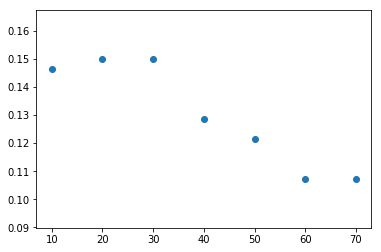

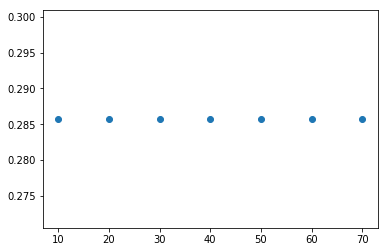

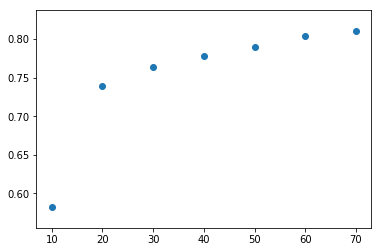

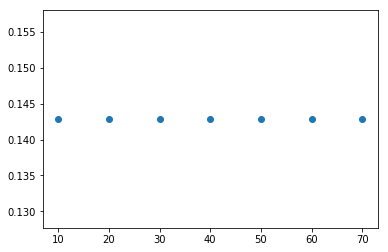

In [0]:
mpl.pyplot.scatter(ep_list21,train_acc_list21)
mpl.pyplot.show()

mpl.pyplot.scatter(ep_list21,val_acc_list21)
mpl.pyplot.show()


mpl.pyplot.scatter(ep_list22,train_acc_list22)
mpl.pyplot.show()

mpl.pyplot.scatter(ep_list22,val_acc_list22)
mpl.pyplot.show()


In [0]:
log_info =1

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def plot_attention(in_seq, out_seq, attentions):
    """ From http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html"""

    out_seq = out_seq
    attentions = attentions
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
#     fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([' '] + [str(x) for x in in_seq], rotation=90)
    ax.set_yticklabels([' '] + [str(x) for x in out_seq])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

line In the figure above , what is the value of x ?
pos_rules ['is value what']


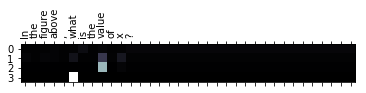

predicted rule  is what value
inc_over 1 0
line The figure above shows six right triangles .
pos_rules []
line What is the value of v ?
pos_rules ['is value What']


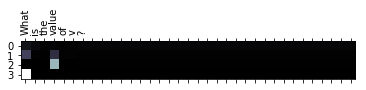

predicted rule  is What value
inc_over 2 0
line In quadrilateral PQRS above , what is the value of v ?
pos_rules ['is value what']


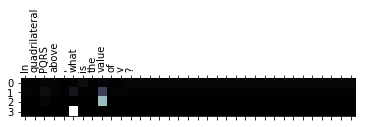

predicted rule  is what value
inc_over 3 0
line In the figure above , point O lies on line AB .
pos_rules ['lies_on O AB']


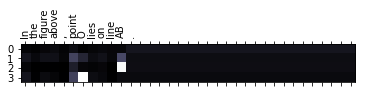

predicted rule  lies O AB
inc_over 4 0
line What is the value of x ?
pos_rules ['is value What']


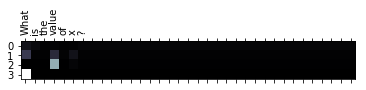

predicted rule  is What value
inc_over 5 0
line In triangle ABC above , the bisector of angle BAC is perpendicular to BC at point D .
pos_rules ['perpendicular bisector BC']


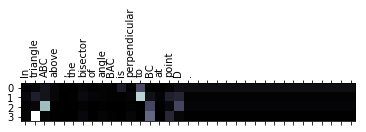

predicted rule  is triangle ABC
inc fp  1
inc_over 5 1


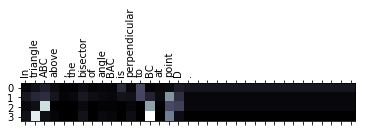

predicted rule  perpendicular BC ABC
inc fp  2
inc_over 5 2
line If s holds and s holds , what is the measure of angle BAC ?
pos_rules ['is measure what']


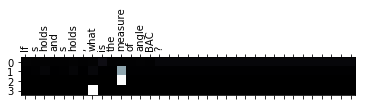

predicted rule  is what measure
inc_over 6 2
line In the figure above , three lines intersect at a point .
pos_rules ['intersect lines point']


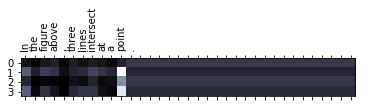

inc fn  1
line What is the value of y ?
pos_rules ['is value What']


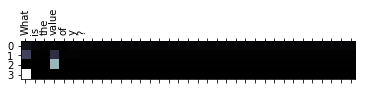

predicted rule  is What value
inc_over 7 2
line In the figure above , the circle has center P and radius r .
pos_rules ['center P circle']


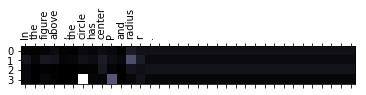

predicted rule  has circle center
inc fp  3
inc_over 7 3


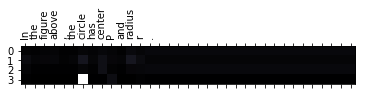

predicted rule  center circle center
inc fp  4
inc_over 7 4
line Lines AB and AC are tangent to the circle .
pos_rules ['tangent AB circle']


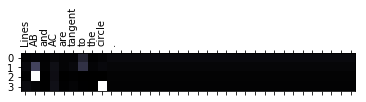

predicted rule  tangent circle AB
inc_over 8 4
line If M is the midpoint of segment AC and the measure of angle PMC equals the measure of angle MPC , what is the length , in terms of r , of segment PA ?
pos_rules ['equals measure measure', 'midpoint M AC', 'is length what']


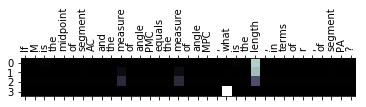

predicted rule  is what length
inc_over 9 4


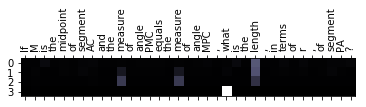

predicted rule  equals what measure
inc fp  5
inc_over 9 5


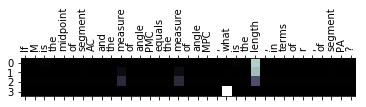

inc fn  2
inc fn  3
line In the figure above , lines l and k intersect at point Q .
pos_rules ['intersect l Q']


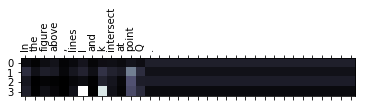

predicted rule  intersect l point
inc fp  6
inc_over 9 6
line If s holds and s holds , what is the value of x ?
pos_rules ['is value what']


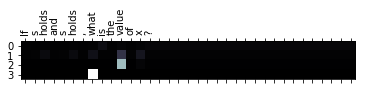

predicted rule  is what value
inc_over 10 6
line In the figure above , triangle ABC is inscribed in the circle with center O and diameter AC .
pos_rules ['inscribed ABC circle', 'center O circle']


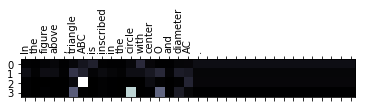

predicted rule  is circle ABC
inc fp  7
inc_over 10 7


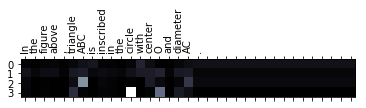

predicted rule  with circle ABC
inc fp  8
inc_over 10 8


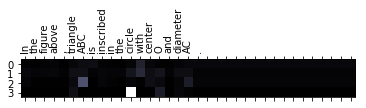

predicted rule  center circle ABC
inc fp  9
inc_over 10 9
inc fn  4
line If s holds , what is the degree measure of angle ABO ?
pos_rules ['is measure what']


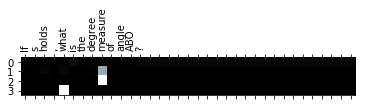

predicted rule  is what measure
inc_over 11 9
line In the figure above , line AB , line CD , and line EF intersect at P .
pos_rules ['intersect EF P']


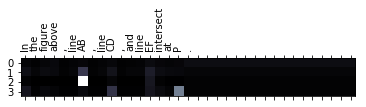

predicted rule  intersect P AB
inc fp  10
inc_over 11 10
line If s holds , s holds , s holds , s holds , and s holds , what is the value of x ?
pos_rules ['is value what']


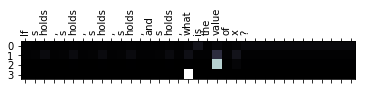

predicted rule  is what value
inc_over 12 10
line In the figure above , PQRS is a rectangle .
pos_rules ['is PQRS rectangle']


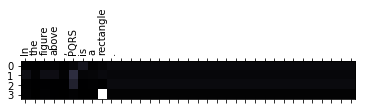

predicted rule  is rectangle PQRS
inc_over 13 10
line The area of triangle RST is 7 and s holds .
pos_rules ['is area 7']


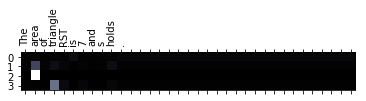

predicted rule  is triangle area
inc fp  11
inc_over 13 11
line What is the area of PQRS ?
pos_rules ['is area What']


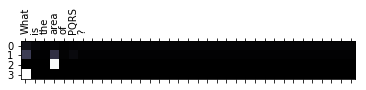

predicted rule  is What area
inc_over 14 11
line In the figure above , point B lies on side AC .
pos_rules ['lies_on B AC']


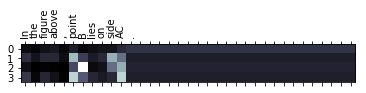

predicted rule  lies point B
inc fp  12
inc_over 14 12
line If s holds , what is one possible value of y ?
pos_rules ['is value what']


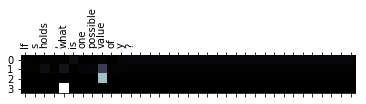

predicted rule  is what value
inc_over 15 12
line In rectangle ABDF above , C and E are midpoints of sides BD and DF , respectively .
pos_rules ['midpoints E BD']


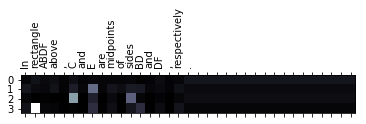

predicted rule  midpoints rectangle C
inc fp  13
inc_over 15 13
line In rectangle ABCD above , the area of the shaded region is given by v .
pos_rules []


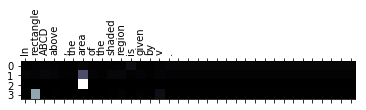

predicted rule  is rectangle area
inc fp  14
inc_over 15 14
line If the area of the shaded region is v , what is the total area , to the nearest whole number , of the unshaded regions of rectangle ABCD ?
pos_rules []


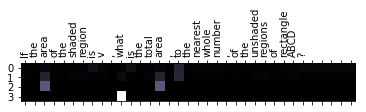

predicted rule  is what area
inc fp  15
inc_over 15 15


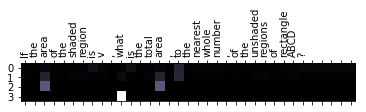

line Point P is the center of the large circle and PA and PB are radii .
pos_rules ['center P circle']


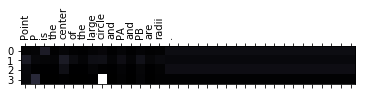

predicted rule  is circle center
inc fp  16
inc_over 15 16


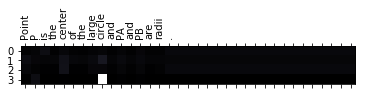

predicted rule  center circle center
inc fp  17
inc_over 15 17
line In the figure above , the circle with center O has radius 7 , AB is a diameter , and s holds .
pos_rules ['has radius 7', 'is AB diameter', 'center O circle']


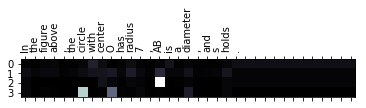

predicted rule  with circle AB
inc fp  18
inc_over 15 18


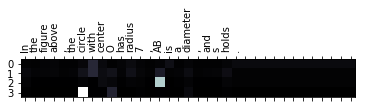

predicted rule  center circle AB
inc fp  19
inc_over 15 19


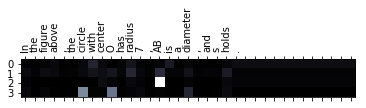

predicted rule  has circle AB
inc fp  20
inc_over 15 20


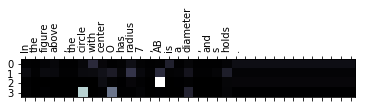

predicted rule  is circle AB
inc fp  21
inc_over 15 21
inc fn  5
inc fn  6
line What is the area of triangle ABC ?
pos_rules ['is area What']


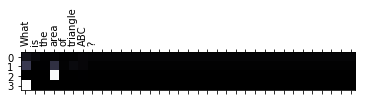

predicted rule  is What area
inc_over 16 21
line In the figure above , lines l and m are not parallel .
pos_rules []


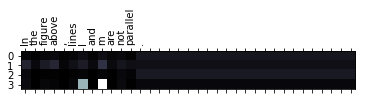

predicted rule  parallel m .
inc fp  22
inc_over 16 22
line In the triangle above , which of the following must be true ?
pos_rules []


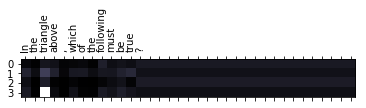

line In the figure above , what is the value of x ?
pos_rules ['is value what']


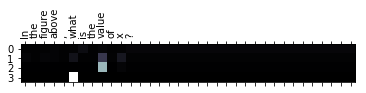

predicted rule  is what value
inc_over 17 22
line The perimeter of the rectangle above is p and the area of the rectangle is 36 .
pos_rules ['is perimeter p', 'is area 36']


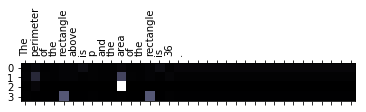

predicted rule  is rectangle area
inc fp  23
inc_over 17 23


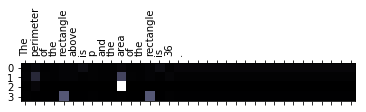

inc fn  7
line If l and w are integers , what is one possible value of p ?
pos_rules ['is value what']


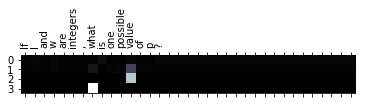

predicted rule  is what value
inc_over 18 23
line In the figure above , if the angle ( not shown ) where lines n and p intersect is twice as large as the angle ( also not shown ) where lines l and m intersect , what is the value of x ?
pos_rules ['is value what']


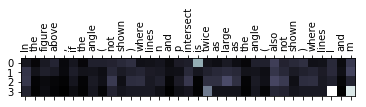

predicted rule  intersect l large
inc fp  24
inc_over 18 24


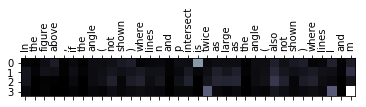

predicted rule  is m also
inc fp  25
inc_over 18 25
line In the figure above , points A and B lie on the circle with center O .
pos_rules ['center O circle', 'lie_on A circle']


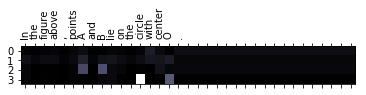

predicted rule  with circle B
inc fp  26
inc_over 18 26


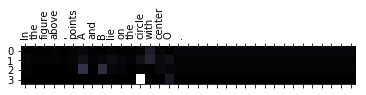

predicted rule  center circle A
inc fp  27
inc_over 18 27
line If s holds , what is the value of z ?
pos_rules ['is value what']


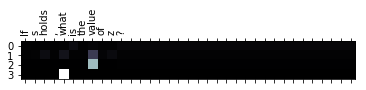

predicted rule  is what value
inc_over 19 27
line If the perimeter of the rectangle above is 72 , what is the value of x ?
pos_rules ['is value what', 'is perimeter 72']


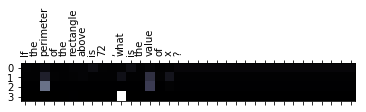

predicted rule  is what perimeter
inc fp  28
inc_over 19 28


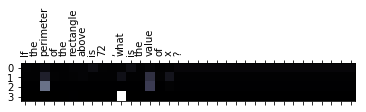

line In triangle ABC above , the length of AB is 3 , and D is the midpoint of AC .
pos_rules ['is length 3', 'midpoint D AC']


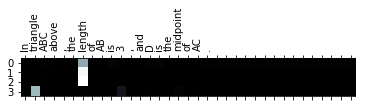

predicted rule  is triangle length
inc fp  29
inc_over 19 29


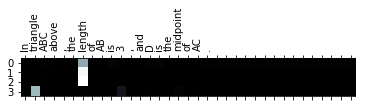

inc fn  8
line What is the length of BC ?
pos_rules ['is length What']


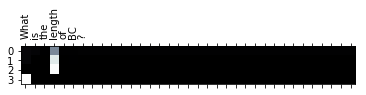

predicted rule  is What length
inc_over 20 29
line In the figure above , CDE is an equilateral triangle and ABCE is a square with an area of 1 .
pos_rules ['with area 1', 'is CDE triangle', 'is ABCE square']


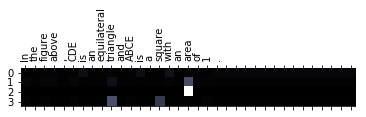

predicted rule  is triangle area
inc fp  30
inc_over 20 30


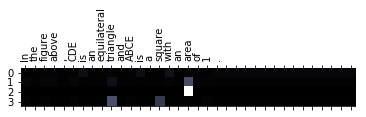

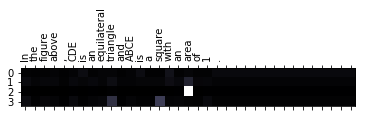

predicted rule  with square area
inc fp  31
inc_over 20 31
inc fn  9
inc fn  10
line What is the perimeter of polygon ABCDE ?
pos_rules ['is perimeter What']


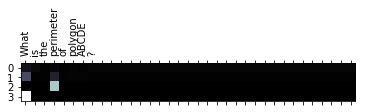

predicted rule  is What perimeter
inc_over 21 31
line In the figure above , if the area of triangle CAF is equal to the area of rectangle CDEF , what is the length of segment AD ?
pos_rules ['equal area area', 'is length what']


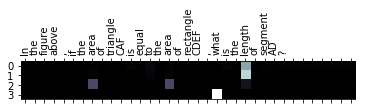

predicted rule  is what area
inc fp  32
inc_over 21 32


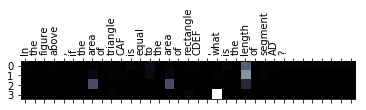

predicted rule  equal what area
inc fp  33
inc_over 21 33


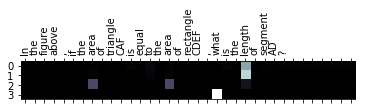

inc fn  11
line If s holds and s holds in the figure above , what is the value of z ?
pos_rules ['is value what']


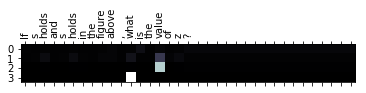

predicted rule  is what value
inc_over 22 33
line In triangle ABC above , s holds , E is the midpoint of line AB , and D is the midpoint of line AC .
pos_rules ['midpoint D AC', 'midpoint E AB']


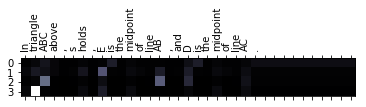

predicted rule  is triangle ABC
inc fp  34
inc_over 22 34


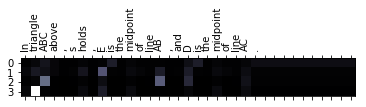

line If s holds and s holds , what is length BC ?
pos_rules ['is length what']


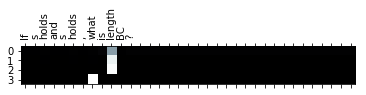

predicted rule  is what length
inc_over 23 34
line In isosceles triangle ABC above , line AM and line CM are the angle bisectors of angle BAC and angle BCA .
pos_rules ['bisectors bisectors BAC', 'are AM bisectors']
inc fn  12
inc fn  13
line What is the measure of angle AMC ?
pos_rules ['is measure What']


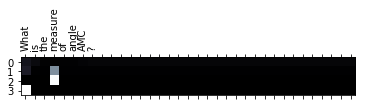

predicted rule  is What measure
inc_over 24 34
line The figure above is composed of 25 small triangles that are congruent and equilateral .
pos_rules []


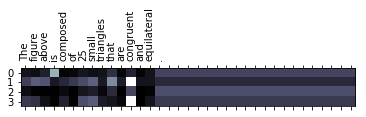

predicted rule  is congruent .
inc fp  35
inc_over 24 35


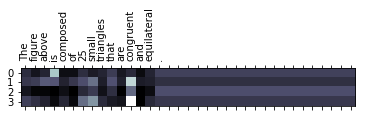

line If the area of triangle DFH is 10 , what is the area of triangle AFK ?
pos_rules ['is area what', 'is area 10']


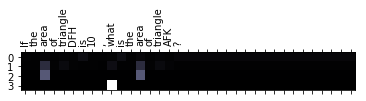

predicted rule  is what area
inc_over 25 35


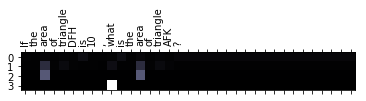

inc fn  14
line In the figure above , a shaded polygon which has equal sides and equal angles is partially covered with a sheet of blank paper .
pos_rules []


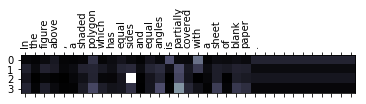

predicted rule  has partially sides
inc fp  36
inc_over 25 36


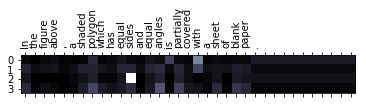

predicted rule  equal angles sides
inc fp  37
inc_over 25 37


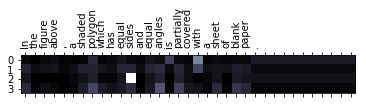

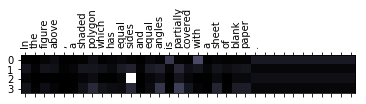

predicted rule  is partially sides
inc fp  38
inc_over 25 38


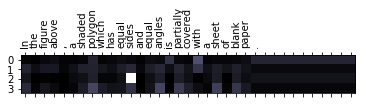

predicted rule  with angles sides
inc fp  39
inc_over 25 39
line If s holds , how many sides does the polygon have ?
pos_rules []
line In the figure above , point B lies on line AC .
pos_rules ['lies_on B AC']


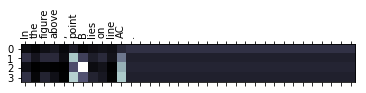

predicted rule  lies point B
inc fp  40
inc_over 25 40
line If x and y are integers , which of the following is a possible value of x ?
pos_rules ['is value which', 'are x integers']


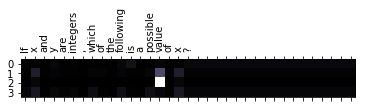

predicted rule  is x value
inc fp  41
inc_over 25 41
inc fn  15
line Point O is the center of both circles in the figure above .
pos_rules ['center O circles']


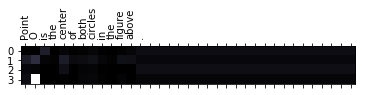

predicted rule  is O center
inc fp  42
inc_over 25 42


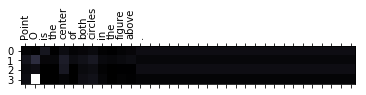

predicted rule  center O center
inc fp  43
inc_over 25 43
line If the circumference of the large circle is 36 and the radius of the small circle is half of the radius of the large circle , what is the length of the darkened arc ?
pos_rules ['is circumference 36', 'is length what']


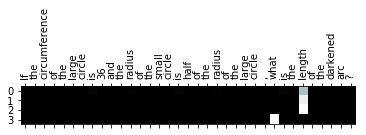

predicted rule  is what length
inc_over 26 43


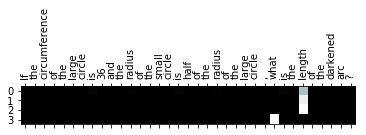

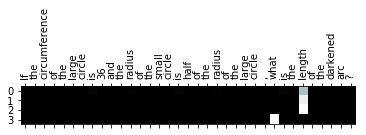

inc fn  16
line In the figure above , P , Q , and R lie on the same line .
pos_rules ['lie_on P line']
inc fn  17
line P is the center of the larger circle , and Q is the center of the smaller circle .
pos_rules ['center P circle', 'center Q circle']


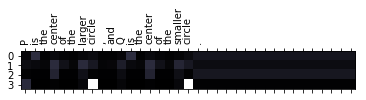

predicted rule  is circle center
inc fp  44
inc_over 26 44


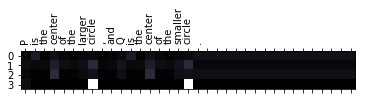

predicted rule  center circle center
inc fp  45
inc_over 26 45


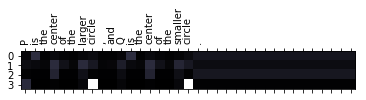

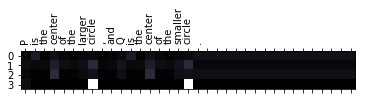

line If the radius of the larger circle is 4 , what is the radius of the smaller circle ?
pos_rules ['is radius what', 'is radius 4']


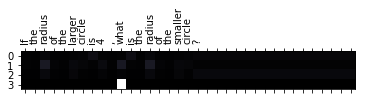

predicted rule  is what radius
inc_over 27 45


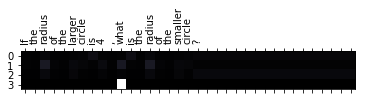

inc fn  18
line The two semicircles in the figure above have centers R and S , respectively .
pos_rules []
line If s holds , what is the total length of the darkened curve ?
pos_rules []


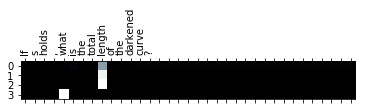

predicted rule  is what length
inc fp  46
inc_over 27 46
line In the figure above , s holds .
pos_rules []
line Which of the following must equal 180 ?
pos_rules ['equal 180 Which']


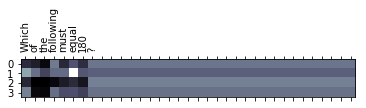

predicted rule  equal Which ?
inc fp  47
inc_over 27 47
line In the figure above , three lines intersect at a point .
pos_rules ['intersect lines point']


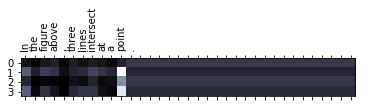

inc fn  19
line If s holds and s holds , what is the value of a ?
pos_rules ['is value what']


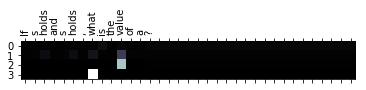

predicted rule  is what value
inc_over 28 47
line In the figure above , triangles ABC and CDE are equilateral and line segment AE has length 25 .
pos_rules ['has length 25']


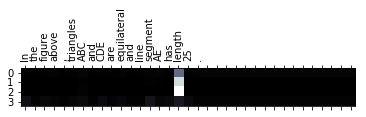

inc fn  20
line What is the sum of the perimeters of the two triangles ?
pos_rules ['is sum What']


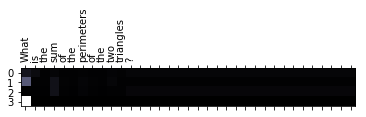

predicted rule  is What sum
inc_over 29 47
line In the figure above , which of the following is the greatest ?
pos_rules []


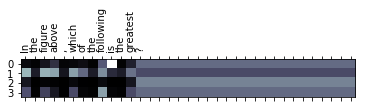

predicted rule  is following ?
inc fp  48
inc_over 29 48
line In the figure above , if s holds and s holds , then s is true
pos_rules []
line In triangle PQR above , s holds .
pos_rules []
line Which of the following must be true ?
pos_rules []


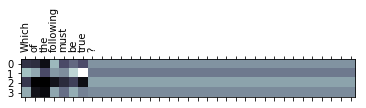

predicted rule  be be ?
inc fp  49
inc_over 29 49
line What is the perimeter of the trapezoid above ?
pos_rules ['is perimeter What']


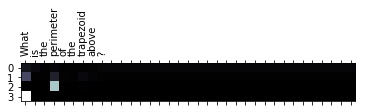

predicted rule  is What perimeter
inc_over 30 49
line In the figure above , the smaller circles each have radius 3 .
pos_rules ['radius 3 circles']
inc fn  21
line They are tangent to the larger circle at points A and C , and are tangent to each other at point B , which is the center of the larger circle .
pos_rules ['center B circle']


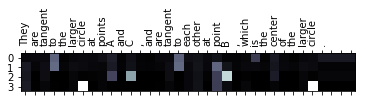

predicted rule  tangent circle B
inc fp  50
inc_over 30 50


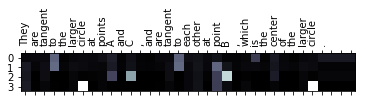

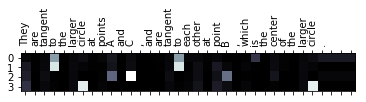

predicted rule  is circle C
inc fp  51
inc_over 30 51


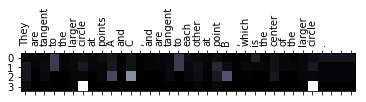

predicted rule  center circle C
inc fp  52
inc_over 30 52
line What is the perimeter of the shaded region ?
pos_rules []


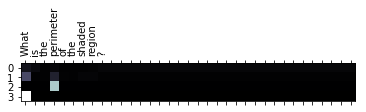

predicted rule  is What perimeter
inc fp  53
inc_over 30 53
line In the figure above , s holds and s holds .
pos_rules []
line Point P lies on line AB between A and B such that line CP is perpendicular to line AB .
pos_rules ['lies_on P AB', 'perpendicular CP AB']


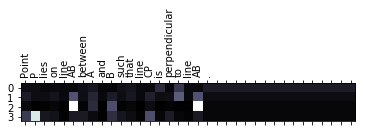

predicted rule  lies P AB
inc_over 31 53


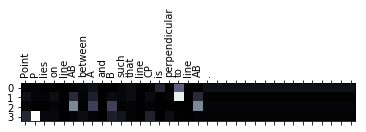

predicted rule  is P AB
inc fp  54
inc_over 31 54


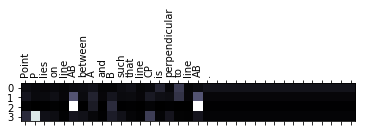

predicted rule  perpendicular P AB
inc fp  55
inc_over 31 55
inc fn  22
line Which of the following could be the length of line CP ?
pos_rules ['be length Which']


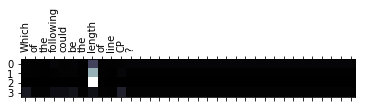

predicted rule  be CP length
inc fp  56
inc_over 31 56
line The figure above shows five lines .
pos_rules []
line If s holds , which of the following is not equal to 90 ?
pos_rules ['equal 90 which']


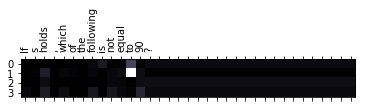

predicted rule  is 90 ?
inc fp  57
inc_over 31 57


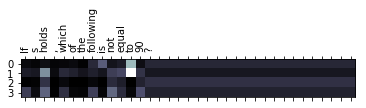

predicted rule  equal not holds
inc fp  58
inc_over 31 58
line The figure above shows three squares with sides of length 5 , 7 , and x , respectively .
pos_rules ['with length 5', 'sides sides squares']


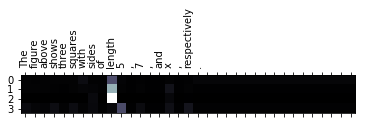

predicted rule  with 5 length
inc_over 32 58
inc fn  23
line If A , B , and C lie on line l , what is the value of x ?
pos_rules ['lie A l', 'is value what']


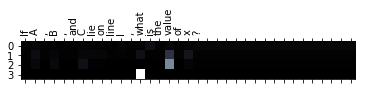

predicted rule  is what value
inc_over 33 58
inc fn  24
line In the figure above , what is the value of y ?
pos_rules ['is value what']


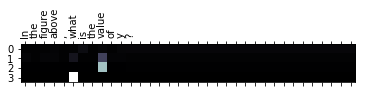

predicted rule  is what value
inc_over 34 58
line In the figure above , ABCDEF is a regular hexagon , and its center is point O .
pos_rules ['is ABCDEF hexagon']


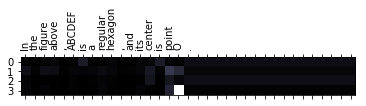

predicted rule  is O point
inc fp  59
inc_over 34 59


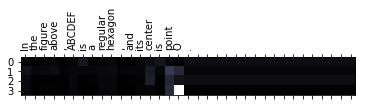

predicted rule  center O point
inc fp  60
inc_over 34 60


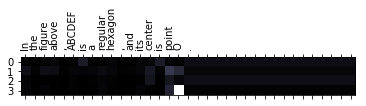

line What is the value of x ?
pos_rules ['is value What']


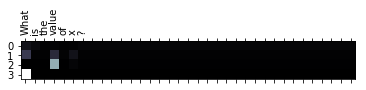

predicted rule  is What value
inc_over 35 60
line The circle above has an area of v and is divided into 8 congruent regions .
pos_rules ['has area v']


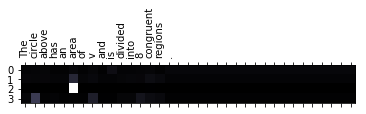

predicted rule  has circle area
inc fp  61
inc_over 35 61


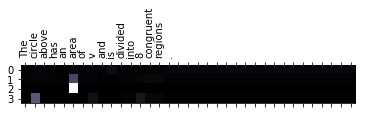

predicted rule  is circle area
inc fp  62
inc_over 35 62


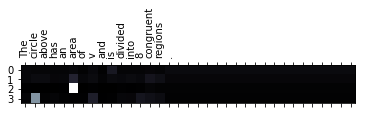

predicted rule  congruent circle area
inc fp  63
inc_over 35 63
line What is the perimeter of these regions ?
pos_rules []


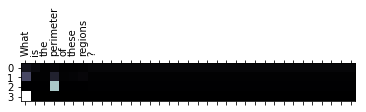

predicted rule  is What perimeter
inc fp  64
inc_over 35 64
line In the figure above , point P is on line l .
pos_rules ['is_on P l']


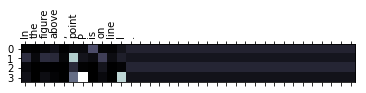

predicted rule  is P point
inc fp  65
inc_over 35 65
line What is the value of x ?
pos_rules ['is value What']


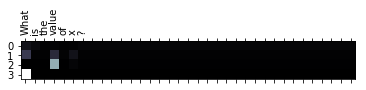

predicted rule  is What value
inc_over 36 65
line In the figure above , side AC of triangle ABC is on line l .
pos_rules []


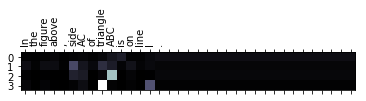

predicted rule  is triangle ABC
inc fp  66
inc_over 36 66
line What is x in terms of k ?
pos_rules []


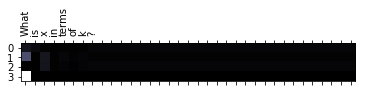

predicted rule  is What x
inc fp  67
inc_over 36 67
line What is the measure of angle CBA ?
pos_rules ['is measure What']


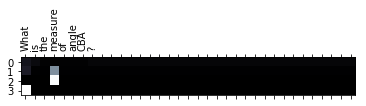

predicted rule  is What measure
inc_over 37 67
37 67 0 24 0.355769230769 0.606557377049 0.448484848485


In [0]:
# In circle O , diameter AB is perpendicular to chord CD at E .##perpendicular AB CD
import re


def predictLong(se):
    raws = se.split('##')[0].split()
    #   print('se', se)
    testS, testQ = se.split('##')
    splitQ = testQ.split(' ')
    tempQ = ' '.join(splitQ[:2])
    tempS = testS + '##' + tempQ + ' point' + ' point'
    #   print('tempS',tempS)
    #   print('parse_stories2([tempS])',np.array(parse_stories2([tempS])).shape, parse_stories2([tempS]))

    s, q, a = parse_stories3([tempS])[0]
    s, q, a = vectorize_datas_for_predict([[s, q, a]], word_idx, sentence_size, memory_size)
    #   print ('tempQ',tempQ)
    #     print('s1',s)
    #     print('q1',q)
    #     print('a1',a)
    a11, att1 = model2.predict(s, q)
#     print('a1', att1)
    att1 = att1.reshape(hops, memory_size)
    #     final_hop = att1[-1]
    a1, a2 = a11[0][0], a11[1][0]
    #     print('att', a1, a2)

#     print('att', np.array(att1).shape)

#     for attt in att1:
#         print('sum ', sum(attt))

    if ((a1 + 1 > len(raws)) or (a2 + 1 > len(raws))):
        return -1, -1
    # plot_attention(raws, ['1', '2', '3'], att1)
    if(log_info):
        plot_attention(raws, [str(i) for i in range(hops)], att1)
    return [a1], [a2]


#   print('lenrange',len(splitQ))
#   for i in range(len(splitQ)-1):
# #     print('i',i)
#     tempQ = ' '.join(splitQ[:i+1])
# #   'point'; a dummy answer
#     tempS = testS+'##'+tempQ+' point'
# #     print(tempS)
#     s,q,a =  parse_stories([tempS])[0]
# #     print('s',s)
#     s,q,a = vectorize_data(s,q,a,word_idx, sentence_size, memory_size)
# #     print('len1',len(s))
#     print (s)
#     print (q)
#     print ('pred',model.predict(s,q))
#   return s,q
# ad = predictLong('In circle O , diameter AB is perpendicular to chord CD at E .','perpendicular AB CD')

# np.array(ad).shape,model.predict(s,q)
# model.predict(s,q)


def evaluate(lines, keyword_dict, rule_dict=rule_dict):
    double_rule_list = list()
    qs = list()
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    selected_rules = list()
    for line in lines:
        #     line.replace('\n','')
        #     line = line[:-1]


        qKey = line.split('##')[0]
        #     print('qKey',qKey)

        pos_rules = list()
        if qKey in rule_dict.keys():
            pos_rules = rule_dict[qKey]

        pos_rule_encs = list()
        pos_rule_encs2 = list()

        for rule in pos_rules:
            #       if(log_info):
            #             print('rule', rule)
            rule_words = rule.split(' ')
            rule1 = [rule_words[0], rule_words[1], rule_words[2]]
            #       rule1 = ' '.join(rule1)
            rule2 = [rule_words[0], rule_words[2], rule_words[1]]
            #       rule2 = ' '.join(rule2)

            #       print('before',[rule_word.replace('@','') for rule_word in rule.split(' ')])
            #       rule_words1 = ''.join([str(word_idx[rule_word.replace('@','')]) for rule_word in rule1])
            rule_words1 = ''.join([str(word_idx[rule_word.replace('@', '')]) for rule_word in rule1])
            rule_words2 = ''.join([str(word_idx[rule_word.replace('@', '')]) for rule_word in rule2])

            lss1 = ''.join(str(rule_words1))
            lss2 = ''.join(str(rule_words2))

            #       print('lss',lss1, lss2)
            pos_rule_encs.append(lss1)
            pos_rule_encs2.append(lss2)

        line = line.split('##')[1]
        if (log_info):
            print('line', line)

        if (log_info):
            print('pos_rules', pos_rules)
        # print('pos_rules_encs',pos_rule_encs)

        words = line.split(' ')

        #   pruning
        if (len(words) > memory_size):
            words = words[:memory_size]
            line = ' '.join(words)

        for wordId in range(len(words)):

            #       print('wordId', wordId),
            word = words[wordId]
            #       print(' word ', word)
            if word in keyword_dict.keys() and keyword_dict[word] == 2:
                if (word == 'on'):
                    continue
#                 temp
                

                a1, a2 = predictLong(line + ' ##' + word)
                if (a1 == a2):
                    continue
                # print('a1', a1, a2)
                pred_word = str(words[a1[0]])
                pred_word2 = str(words[a2[0]])
                #                 print('predicted rule before ', word, pred_word, pred_word2)
                if containRuleAlready(qKey, word, pred_word, pred_word2, double_rule_list):
                    continue
                print('predicted rule ', word, pred_word, pred_word2)
                if((word.lower() in ['lies','lie']) or (word.lower()=='is' and words[wordId+1]=='on' )):
                  word =word + '_on'
                #         if(a1 == -1 or (not pred_word.isalnum()) or(pred_word.islower() and len(pred_word)>1)):
                #           continue
                #         if(a2 == -1 or (not pred_word2.isalnum()) or(pred_word2.islower() and len(pred_word2)>1)):
                #           continue

                #         print('a1', a1)
                word_id = word_idx[word]
                lss3 = ''.join([str(word_id), str(word_idx[words[a1[0]].replace('@', '')]),
                                str(word_idx[words[a2[0]].replace('@', '')])])
                lss4 = ''.join([str(word_id), str(word_idx[words[a2[0]].replace('@', '')]),
                                str(word_idx[words[a1[0]].replace('@', '')])])
                #         double_rule_list.append(qKey+'##'+word+' ' + word_idx.keys()[word_idx.values().index(a1)]
                double_rule_list.append(qKey + '##' + word + ' ' + pred_word2 + ' ' + pred_word)
                selected_rules.append(lss1)
                #         predicted_rule = word + ' ' +a1
                if containList(lss3, lss4, pos_rule_encs, 'tp'):
                    tp = tp + 1                    
                else:
                    fp = fp + 1
                    if (log_info):
                      print('inc fp ', fp)
                if (log_info):
                    print('inc_over', tp, fp)

        for ruleId in range(len(pos_rule_encs)):
            #       print('ruleId', ruleId)
            #       print('pos_rule_encs', pos_rule_encs, )
            if not containList(pos_rule_encs[ruleId], pos_rule_encs2[ruleId], selected_rules, 'fp'):
                fn = fn + 1
                if (log_info):
                    print('inc fn ',fn)

    double_rule_list = list(set(double_rule_list))
    predict_double_rule_file = open("predict_double_rule_file_mm.txt", "w+")
    for v in double_rule_list:
        predict_double_rule_file.write(v)
        predict_double_rule_file.write('\n')
    predict_double_rule_file.close()

    return tp, fp, tn, fn


def containList(list1, list2, lists, a):
    #   print(a,list1,'##',lists)
    #   print('lists',lists)
    #   print('list1',list1)

    #   list_ind =int(''.join(str(x) for x in list1))
    #   list_ints = list()

    #   for i in lists:
    # #     print('i',i)
    # #     print('gen',int(''.join(str(x) for x in i)))
    #     list_ints.append(''.join(str(x).strip()) for x in i if len(''.join(str(x)).strip())>0)
    if (list1 in lists) or (list2 in lists):
        return True
    return False


def containRuleAlready(qKey, word, pred_word, pred_word2, double_rule_list):
    rule11 = qKey + '##' + word + ' ' + pred_word + ' ' + pred_word2
    rule12 = qKey + '##' + word + ' ' + pred_word2 + ' ' + pred_word
    if (rule11 in double_rule_list) or (rule12 in double_rule_list):
        return True
    return False


# predictLong('In triangle ABC above , the length of AB is 3 , and D is the midpoint of AC .##midpoint D AC')
# predictLong('What is the length of segment AB ?##length AB')

tp, fp, tn, fn = evaluate(evaluate_data, keyword_dict)
precison = 1.0 * tp / (tp + fp)
recall = 1.0 * tp / (tp + fn)
f1Score = 2.0 * precison * recall / (precison + recall)

print(tp, fp, tn, fn, precison, recall, f1Score)


In [0]:
inc_over 38 53
38 53 0 26 0.417582417582 0.59375 0.490322580645

In [0]:
inc 35 57
35 57 0 33 0.380434782609 0.514705882353 0.4375

In [0]:
inc 32 69
32 69 0 29 0.316831683168 0.524590163934 0.395061728395

In [0]:
inc 20 21
20 21 0 54 0.487804878049 0.27027027027 0.347826086957

inc 29 53
29 53 0 36 0.353658536585 0.446153846154 0.394557823129

In [0]:
# 23 93 0 32 0.198275862069 0.418181818182 0.269005847953

In [0]:
word_idx['v_0']

141

In [0]:
line1 = ['1025#0##BCA is a triangle']
evaluate(line1,keyword_dict)

NameError: ignored

In [0]:
keyword_dict

{'Circle': 1,
 'Diameter': 2,
 'Find': 1,
 'Line': 1,
 'Points': 1,
 'Rectangle': 1,
 'Segment': 1,
 'Triangle': 1,
 'Two': 1,
 'What': 0,
 'altitude': 2,
 'angle': 1,
 'angles': 1,
 'arc': 1,
 'arcs': 1,
 'area': 1,
 'average': 1,
 'be': 2,
 'center': 2,
 'chord': 2,
 'chords': 2,
 'circle': 1,
 'congruent': 2,
 'correct': 1,
 'degrees': 1,
 'diameter': 1,
 'equal': 2,
 'equals': 2,
 'equilateral': 1,
 'has': 2,
 'height': 1,
 'hypotenuse': 2,
 'intersect': 2,
 'intersects': 2,
 'is': 2,
 'isosceles': 1,
 'leg': 2,
 'length': 2,
 'lies': 2,
 'line': 1,
 'lines': 1,
 'measure': 1,
 'measures': 1,
 'meet': 2,
 'midpoints': 2,
 'not': 1,
 'on': 2,
 'parallel': 2,
 'perimeter': 1,
 'perpendicular': 2,
 'point': 1,
 'points': 1,
 'quadrilateral': 1,
 'radius': 1,
 'ratio': 2,
 'rectangle': 1,
 'rhombus': 1,
 'right': 1,
 'secant': 2,
 'secants': 2,
 'sector': 1,
 'segment': 1,
 'side': 2,
 'sides': 2,
 'six': 1,
 'square': 1,
 'sum': 1,
 'tangent': 2,
 'tangents': 2,
 'trapezoid': 1,
 'tri

In [0]:
double_rule_list = list(set(double_rule_list))
for v in double_rule_list:
  print(v)

1470#1##is area What
1482#0##is AB length
1485#0##is area what
1484#3##is area What
1032#0##is D point
1476#0##is value what
1032#0##perpendicular BC point
968#1##is measure what
968#0##is O circle
974#0##is value what
1479#1##is value what
969#0##intersect AB EF
1020#1##is value What
1005#1##center A B
971#0##is area square
1037#1##tangent AB circle
1482#1##is length What
1037#2##is measure length
1027#1##is value What
1479#0##center O circle
1473#0##with AB O
1006#2##be length Which
1473#1##is area What
977#1##is measure What
975#1##is length what
968#0##center circle O
963#1##is value what
1481#0##is value what
1031#0##lies_on AB point
1477#1##is value what
1025#0##is value what
1019#1##is perimeter What
1473#0##center AB O
985#0##lies_on B AC
1031#1##is value What
1005#1##tangent A B
1035#1##is value What
995#1##is sum What
1473#0##is AB O
1467#0##lies_on B AC
1030#0##is value what
993#1##is value what
1037#2##equals length measure
1467#1##is value what
1151#0##is measure What
1037

In [0]:
np.sort([int(val) for val in word_idx.values() if val!='time1'])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [0]:
vocab[1]

'illustrates'

In [0]:

for i in range(6):
  s = [[word_idx.keys()[word_idx.values().index(j)]] for j in testS[i][0] if j>0 and j<220]
  print (s)

[['The'], ['measure'], ['of'], ['angle'], ['BAC'], ['equals'], ['@'], ['v_0']]
[['In'], ['the'], ['figure'], ['above'], [','], ['point'], ['B'], ['lies'], ['on'], ['side'], ['AC']]
[['In'], ['rectangle'], ['ABDF'], ['above'], [','], ['C'], ['and'], ['E'], ['are'], ['midpoints'], ['of'], ['sides'], ['BD'], ['and'], ['DF'], [','], ['respectively']]
[['Point'], ['P'], ['is'], ['the'], ['center'], ['of'], ['the'], ['large'], ['circle'], ['and'], ['PA'], ['and'], ['PB'], ['are'], ['radii']]
[['In'], ['the'], ['figure'], ['above'], [','], ['the'], ['circle'], ['with'], ['center'], ['O'], ['has'], ['radius'], ['7'], [','], ['AB'], ['is'], ['a'], ['diameter'], [','], ['and'], ['@'], ['s_0'], ['holds']]
[['In'], ['the'], ['figure'], ['above'], [','], ['the'], ['circle'], ['with'], ['center'], ['O'], ['has'], ['radius'], ['7'], [','], ['AB'], ['is'], ['a'], ['diameter'], [','], ['and'], ['@'], ['s_0'], ['holds']]


In [0]:

for i in range(6):
  s = [[word_idx.keys()[word_idx.values().index(j)]] for j in testQ[i] if j>0 and j<7974]
  print (s)

[['equals']]
[['lies_on'], ['B']]
[['midpoints'], ['C']]
[['center'], ['P']]
[['has'], ['radius']]
[['center'], ['O']]


In [0]:
[word_idx.keys()[word_idx.values().index(i)] for i in test_preds[:6]]

['BAC', 'AC', 'D', 'circle', 'AB', 'AB']

In [0]:
from operator import __mul__
se = [1,2,3]
reduce(__mul__,se,1)

6

In [0]:
[word_idx.keys()[word_idx.values().index(i)] for i in test_labels[:6]]

['measure', 'AC', 'BD', 'circle', '7', 'circle']

In [0]:
testS[5][0]
[j for j in train_labels[5][0]]

42894

In [0]:
testQ[5],trainQ[5],len([a for a in trainQ if sum(p>0 for p in a)>1])

(array([103,  59,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([166,  39,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
 90)

In [0]:
word_idx.keys()[word_idx.values().index(3171)]


'In'

In [0]:
len(word_idx)

7974

In [0]:
import re
parse_stories(['In circle O , diameter AB is perpendicular to chord CD at E .##perpendicular AB CD',
'In circle O , diameter AC is perpendicular to chord AD at E .##perpendicular AC AD'])

[([['In',
    'circle',
    'O',
    ',',
    'diameter',
    'AB',
    'is',
    'perpendicular',
    'to',
    'chord',
    'CD',
    'at',
    'E']],
  ['perpendicular', 'AB'],
  'CD'),
 ([['In',
    'circle',
    'O',
    ',',
    'diameter',
    'AC',
    'is',
    'perpendicular',
    'to',
    'chord',
    'AD',
    'at',
    'E']],
  ['perpendicular', 'AC'],
  'AD')]

In [0]:
[word_idx.keys()[word_idx.values().index(i)] for i in test_preds[:5]]

[' l', 'le', ' O', 'CD', ' O']

In [0]:
for story in testS[:5]:
  for sentence in story:
    print ([word_idx.keys()[word_idx.values().index(i)] for i in sentence if i!=0 and i!=8010])



['In', 'circle', 'O', ',', 'diameter', 'IB', 'is', 'perpendicular', 'to', 'chord', 'IC', 'at', 'E']
['In', 'circle', 'O', ',', 'diameter', 'IC', 'is', 'perpendicular', 'to', 'chord', 'ID', 'at', 'E']
['In', 'circle', 'O', ',', 'diameter', 'ID', 'is', 'perpendicular', 'to', 'chord', 'IE', 'at', 'E']
['In', 'circle', 'O', ',', 'diameter', 'IE', 'is', 'perpendicular', 'to', 'chord', 'IF', 'at', 'E']
['In', 'circle', 'O', ',', 'diameter', 'IF', 'is', 'perpendicular', 'to', 'chord', 'IG', 'at', 'E']


In [0]:
[word_idx.keys()[word_idx.values().index(i)] for i in test_labels[:5]]

In [0]:
[word_idx.keys()[word_idx.values().index(i)] for i in test_labels[:5]]

['IC', 'ID', 'IE', 'IF', 'IG']

In [0]:
class AB(object):
  def __init__(self):
    self.asw = 5
  def getAs(self):
    return self.asw
  
errw = AB()
print(errw.getAs())

5


In [0]:
# np.argmax(train_preds[0])
# word_idx.keys()[word_idx.values().index(1325)]
len(train_preds)

1600

In [0]:
story12 =  ['The', 'diagram', 'below', 'illustrates', 'the', 'construction', 'of', 'line', 'PS', 'parallel', 'to', 'line', 'RQ', 'through', 'point', 'P']
query12 =  ['parallel']
answer12 =  ['PS']
story12.index(answer12[0])

story12.index(query12[0])

9

In [0]:
data2[0][0]
# max_story_size1 = max(map(len, (s for s, _, _ in data2)))
# mean_story_size = int(np.mean([ len(s) for s, _, _ in data2 ]))
# sentence_size = max(map(len, chain.from_iterable(s for s, _, _ in data2)))
# query_size = max(map(len, (q for _, q, _ in data2)))
# memory_size = min(memory_size, max_story_size)
np.array(trainS2).shape
trainS2[100]

[[522],
 [521],
 [520],
 [519],
 [518],
 [517],
 [136, 516],
 [515],
 [514],
 [513],
 [512],
 [419, 511],
 [510],
 [389, 509],
 [136, 508],
 [507],
 [506],
 [505],
 [504],
 [419, 503],
 [502],
 [407, 501],
 [500],
 [499],
 [498],
 [497],
 [496],
 [495],
 [136, 494],
 [493],
 [11, 492],
 [491],
 [490],
 [0],
 [0]]

In [0]:
anneal_stop_epoch = 100
anneal_rate = 10
anneal_rates = [(i+1)*5 for i in range(200) if (i+1)*5<=200]
unknowns = [i+1 for i in range(10)]
anneal_stops = [(i+1)*100 for i in range(17) if (i+1)*100<=1600]
for an in unknowns:
#   anneal_rate = an
  lr_list = list()
  for t in range(1, epochs+1):
      # Stepped learning rate
      if t - 1 <= anneal_stop_epoch:
          anneal = 1.2 ** ((t - 1) // anneal_rate)
      else:
          anneal = 1.2 ** (anneal_stop_epoch // anneal_rate)
      lr = learning_rate / anneal
      lr_list.append(lr)

  mpl.pyplot.scatter([i for i in range(1600)],lr_list)
  mpl.pyplot.show()    
    

559